In [ ]:
!nvidia-smi

Sat Jun  3 02:28:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
# %cd {HOME}
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-" -O vehicle-counting.mp4 && rm -rf /tmp/cookies.txt

In [ ]:
SOURCE_VIDEO_PATH ="/content/BEAUTIFUL-British-Airways-Airbus-A350-Landing-Heathrow-Airpo.mp4"

In [ ]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.112 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.3/78.2 GB disk)


In [ ]:
!pip install loguru

In [ ]:
!pip install yolox

In [ ]:
!pip install thop

In [ ]:
!pip install lap

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [ ]:
# settings
#MODEL = "/content/drive/MyDrive/best.pt"

MODEL="yolov8m.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 49.7M/49.7M [00:00<00:00, 196MB/s]
YOLOv8m summary (fused): 218 layers, 25886080 parameters, 0 gradients


In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = {4: 'airplane'}
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [4]

In [ ]:
model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou


0: 640x384 1 airplane, 76.1ms
Speed: 16.9ms preprocess, 76.1ms inference, 20.3ms postprocess per image at shape (1, 3, 640, 640)


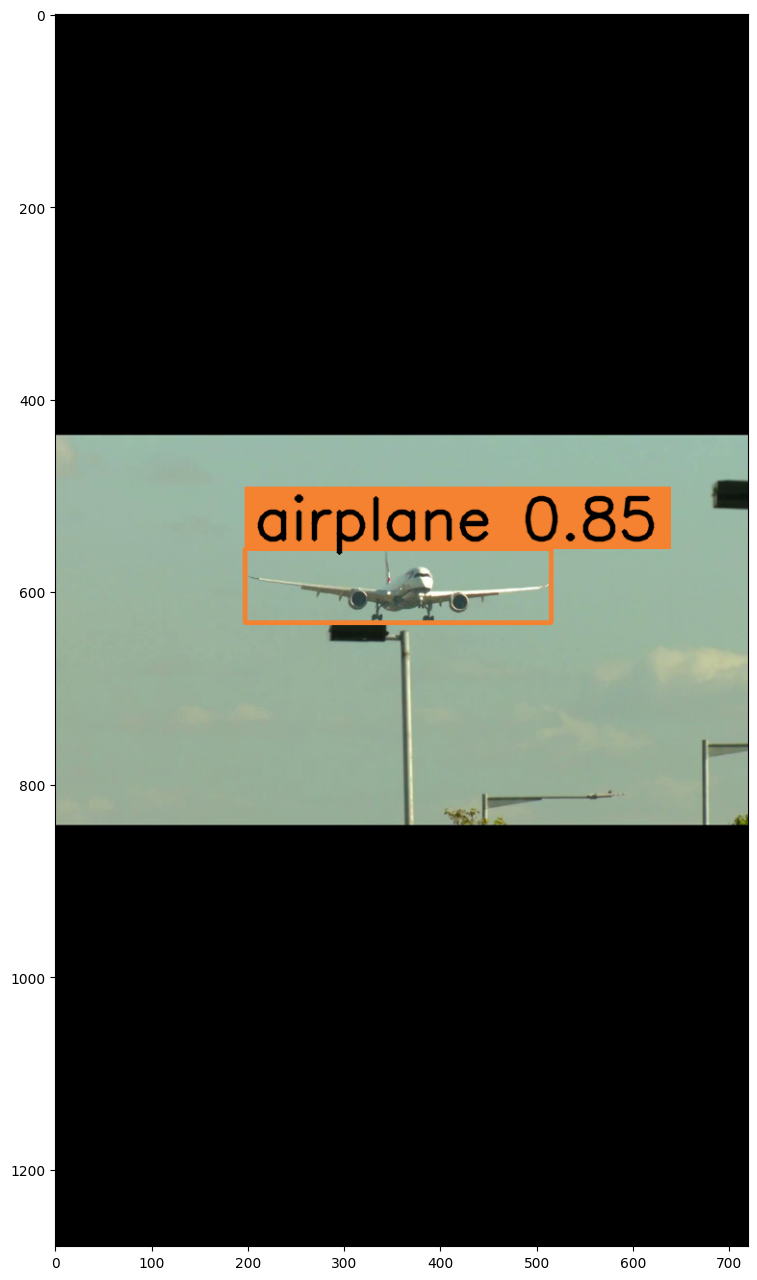

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [ ]:
# settings
LINE_START = Point(50, 150)
LINE_END = Point(320, 150)

TARGET_VIDEO_PATH = f"{HOME}/result.mp4"

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=720, height=1280, fps=25, total_frames=1326)

In [ ]:
import cv2
from tqdm.notebook import tqdm

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        
        # Draw bounding boxes and write coordinates on each frame
        for track in tracks:
            track_id = track.track_id
            coordinates = track.tlwh
            print(f"Track ID: {track_id}, Coordinates: {coordinates}")
            
            
            # Draw the bounding box
            bbox_color = (0, 255, 0)  # Green color
            bbox_thickness = 2
            cv2.rectangle(frame, (int(coordinates[0]), int(coordinates[1])),
                          (int(coordinates[0] + coordinates[2]), int(coordinates[1] + coordinates[3])),
                          bbox_color, bbox_thickness)
            
            # Write the coordinates on the frame
            text = f"{coordinates}"
            text_color = (0, 0, 255)  # Red color
            text_scale = 0.6
            text_thickness = 1
            font = cv2.FONT_HERSHEY_SIMPLEX
            text_x = int(coordinates[0])
            text_y = int(coordinates[1]) - 10 if int(coordinates[1]) >= 20 else int(coordinates[1]) + 20
            
            cv2.putText(frame, text, (text_x, text_y), font, text_scale, text_color, text_thickness, cv2.LINE_AA)
        
        # Write the annotated frame to the target video file
        sink.write_frame(frame)


  0%|          | 0/1326 [00:00<?, ?it/s]


0: 640x384 1 airplane, 25.5ms
Speed: 5.4ms preprocess, 25.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.5ms
Speed: 3.0ms preprocess, 25.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.7ms
Speed: 2.7ms preprocess, 25.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.4ms


Track ID: 1, Coordinates: [     197.31      555.58      318.41      77.254]
Track ID: 1, Coordinates: [     197.83      555.05      318.16      77.194]
Track ID: 1, Coordinates: [     204.16      554.32       310.2      75.184]


Speed: 2.9ms preprocess, 25.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.4ms
Speed: 2.9ms preprocess, 25.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.5ms
Speed: 2.6ms preprocess, 25.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 30.8ms
Speed: 2.5ms preprocess, 30.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     205.35      553.22      310.46       75.17]
Track ID: 1, Coordinates: [     206.46      552.27      310.13       74.97]
Track ID: 1, Coordinates: [      206.3      551.44      311.89      75.268]



0: 640x384 1 airplane, 41.5ms
Speed: 19.5ms preprocess, 41.5ms inference, 18.7ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     204.21      550.01       318.2      76.786]
Track ID: 1, Coordinates: [     205.74       549.3       317.3      76.486]


0: 640x384 1 airplane, 26.1ms
Speed: 2.6ms preprocess, 26.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 28.0ms
Speed: 7.8ms preprocess, 28.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.8ms
Speed: 3.7ms preprocess, 25.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 24.4ms
Speed: 4.2ms preprocess, 24.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     207.39       549.5      316.49      76.173]
Track ID: 1, Coordinates: [     207.37      548.55      320.11      77.054]
Track ID: 1, Coordinates: [     207.16      547.69      322.08      77.554]
Track ID: 1, Coordinates: [     208.88      547.81       321.6      77.424]



0: 640x384 1 airplane, 23.3ms
Speed: 3.5ms preprocess, 23.3ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 27.4ms
Speed: 3.1ms preprocess, 27.4ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 23.4ms
Speed: 2.4ms preprocess, 23.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     207.32      546.63      326.98      78.872]
Track ID: 1, Coordinates: [     208.18      546.72      328.06      79.272]
Track ID: 1, Coordinates: [     206.68      545.52      332.74      80.642]


0: 640x384 1 airplane, 23.5ms
Speed: 6.0ms preprocess, 23.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 23.3ms
Speed: 2.2ms preprocess, 23.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 54.1ms


Track ID: 1, Coordinates: [     208.54      545.38      330.74      80.219]
Track ID: 1, Coordinates: [     210.05      545.05      329.65      80.003]


Speed: 5.8ms preprocess, 54.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 28.5ms
Speed: 5.2ms preprocess, 28.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 52.6ms
Speed: 2.5ms preprocess, 52.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     212.79      544.57       326.4      79.156]
Track ID: 1, Coordinates: [     212.34      544.09      328.49       79.73]
Track ID: 1, Coordinates: [     212.34      543.76      327.19       79.34]



0: 640x384 1 airplane, 23.4ms
Speed: 2.5ms preprocess, 23.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 41.0ms
Speed: 2.2ms preprocess, 41.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     211.54      543.82      327.84      79.476]
Track ID: 1, Coordinates: [     207.48      542.95       334.9      81.442]


0: 640x384 1 airplane, 58.2ms
Speed: 22.6ms preprocess, 58.2ms inference, 20.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 30.4ms
Speed: 2.4ms preprocess, 30.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 37.0ms
Speed: 6.7ms preprocess, 37.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     203.25      541.91      340.13      83.106]
Track ID: 1, Coordinates: [     205.35      541.75      332.07      81.079]
Track ID: 1, Coordinates: [     205.57      541.04      327.41      79.857]



0: 640x384 1 airplane, 32.8ms
Speed: 2.5ms preprocess, 32.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 24.8ms
Speed: 7.2ms preprocess, 24.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 39.7ms
Speed: 5.3ms preprocess, 39.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     201.56      540.68       332.3      81.235]
Track ID: 1, Coordinates: [     201.16      541.02      329.88      80.617]
Track ID: 1, Coordinates: [     197.47      540.49      332.78      81.427]



0: 640x384 1 airplane, 29.7ms
Speed: 9.3ms preprocess, 29.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 32.0ms
Speed: 2.3ms preprocess, 32.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 23.4ms
Speed: 2.0ms preprocess, 23.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 26.8ms
Speed: 2.2ms preprocess, 26.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     196.26      540.53      331.85       81.22]
Track ID: 1, Coordinates: [        195      539.31      331.18      81.038]
Track ID: 1, Coordinates: [     195.54      538.92       328.8      80.357]
Track ID: 1, Coordinates: [     193.41      538.01      331.48      81.028]



0: 640x384 1 airplane, 42.2ms
Speed: 4.2ms preprocess, 42.2ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 51.8ms
Speed: 2.3ms preprocess, 51.8ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 39.4ms


Track ID: 1, Coordinates: [      192.8      537.66      331.73      81.064]
Track ID: 1, Coordinates: [     192.46      537.58      331.65      81.005]


Speed: 2.3ms preprocess, 39.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.4ms
Speed: 2.2ms preprocess, 25.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 29.6ms
Speed: 2.2ms preprocess, 29.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     192.09      537.55      332.19      81.109]
Track ID: 1, Coordinates: [     193.26      538.69       328.9      80.147]
Track ID: 1, Coordinates: [     192.41      538.89       329.2      80.103]


0: 640x384 1 airplane, 29.8ms
Speed: 2.3ms preprocess, 29.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 31.0ms
Speed: 2.2ms preprocess, 31.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.4ms
Speed: 3.4ms preprocess, 25.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.4ms
Speed: 2.4ms preprocess, 25.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     190.48      539.02      330.44      80.293]
Track ID: 1, Coordinates: [     188.04      538.67      332.92      80.893]
Track ID: 1, Coordinates: [     184.99       538.5      334.77      81.379]
Track ID: 1, Coordinates: [     184.25      539.41      331.69      80.512]


0: 640x384 1 airplane, 25.6ms
Speed: 3.4ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.5ms
Speed: 3.4ms preprocess, 25.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.5ms
Speed: 3.6ms preprocess, 20.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.5ms
Speed: 2.5ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.5ms
Speed: 2.1ms preprocess, 20.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     182.38      540.08       330.8      80.138]
Track ID: 1, Coordinates: [     178.31      539.54      335.08       81.25]
Track ID: 1, Coordinates: [     176.24      539.18      335.61      81.397]
Track ID: 1, Coordinates: [     177.05      540.35      330.93      80.089]
Track ID: 1, Coordinates: [     175.88      540.99      329.79      79.643]



0: 640x384 1 airplane, 20.5ms
Speed: 2.2ms preprocess, 20.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.5ms
Speed: 2.3ms preprocess, 20.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.8ms
Speed: 12.0ms preprocess, 19.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.5ms
Speed: 2.9ms preprocess, 19.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.7ms
Speed: 2.3ms preprocess, 19.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     174.72      541.05      330.71      79.743]
Track ID: 1, Coordinates: [     173.09      541.36      332.37      80.059]
Track ID: 1, Coordinates: [     172.25      541.71      333.04      80.131]
Track ID: 1, Coordinates: [     170.77      541.66      335.01      80.602]
Track ID: 1, Coordinates: [     167.41      541.06      339.87      81.885]


0: 640x384 1 airplane, 19.1ms
Speed: 3.7ms preprocess, 19.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.6ms
Speed: 2.6ms preprocess, 17.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 2.1ms preprocess, 17.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 24.3ms
Speed: 2.1ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.5ms
Speed: 2.3ms preprocess, 19.5ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     165.55      541.02      341.48      82.319]
Track ID: 1, Coordinates: [     165.85      542.35      337.73      81.346]
Track ID: 1, Coordinates: [     165.42      542.83      337.17      81.203]
Track ID: 1, Coordinates: [     164.51      543.27      337.84      81.352]
Track ID: 1, Coordinates: [     162.55      543.37      340.32      81.985]



0: 640x384 1 airplane, 17.4ms
Speed: 4.3ms preprocess, 17.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 29.8ms
Speed: 2.7ms preprocess, 29.8ms inference, 12.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.9ms
Speed: 2.6ms preprocess, 19.9ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     161.92      543.36      341.29      82.274]
Track ID: 1, Coordinates: [     161.26       543.8      341.36      82.271]
Track ID: 1, Coordinates: [     160.29      543.68       342.9      82.677]


0: 640x384 1 airplane, 38.5ms
Speed: 2.3ms preprocess, 38.5ms inference, 18.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 29.6ms
Speed: 10.7ms preprocess, 29.6ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     160.34      543.22      344.61        83.1]
Track ID: 1, Coordinates: [     161.33      543.32      344.35      83.066]


0: 640x384 1 airplane, 27.3ms
Speed: 2.3ms preprocess, 27.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 38.8ms
Speed: 2.4ms preprocess, 38.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     162.25      543.43      344.32      83.059]
Track ID: 1, Coordinates: [     162.67      543.47      344.55      83.092]


0: 640x384 1 airplane, 55.0ms
Speed: 11.2ms preprocess, 55.0ms inference, 10.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 86.7ms


Track ID: 1, Coordinates: [     162.11      543.39       346.3      83.581]


Speed: 2.4ms preprocess, 86.7ms inference, 18.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 36.6ms
Speed: 2.3ms preprocess, 36.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 45.5ms
Speed: 2.3ms preprocess, 45.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     161.76      543.32      347.57      84.002]
Track ID: 1, Coordinates: [     162.15       543.5      348.13      84.204]
Track ID: 1, Coordinates: [     161.98      543.55      349.16      84.552]



0: 640x384 1 airplane, 28.3ms
Speed: 2.1ms preprocess, 28.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 33.9ms
Speed: 2.2ms preprocess, 33.9ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 23.9ms
Speed: 4.4ms preprocess, 23.9ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [      162.1      543.85      349.25      84.677]
Track ID: 1, Coordinates: [        162      543.94      349.44      84.807]
Track ID: 1, Coordinates: [     162.17      543.88      350.01       85.02]



0: 640x384 1 airplane, 34.4ms
Speed: 2.2ms preprocess, 34.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 37.8ms
Speed: 4.2ms preprocess, 37.8ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.5ms
Speed: 2.2ms preprocess, 25.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     162.18      543.93      350.69       85.27]
Track ID: 1, Coordinates: [     161.56      543.83       351.4      85.511]
Track ID: 1, Coordinates: [     161.44      543.82      352.28      85.838]



0: 640x384 1 airplane, 29.9ms
Speed: 16.3ms preprocess, 29.9ms inference, 12.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 46.6ms
Speed: 2.3ms preprocess, 46.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     163.57      544.89       349.3      85.058]
Track ID: 1, Coordinates: [     165.03      545.42       347.5      84.552]


0: 640x384 1 airplane, 70.9ms
Speed: 3.3ms preprocess, 70.9ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 63.2ms
Speed: 2.6ms preprocess, 63.2ms inference, 11.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     162.85      544.68      353.21      86.095]
Track ID: 1, Coordinates: [     164.11      545.36      351.72      85.755]


0: 640x384 1 airplane, 43.4ms
Speed: 3.8ms preprocess, 43.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 42.3ms
Speed: 2.6ms preprocess, 42.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 33.8ms
Speed: 3.3ms preprocess, 33.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     164.61      545.47      352.15        85.9]
Track ID: 1, Coordinates: [     164.07      544.92      353.94      86.451]



0: 640x384 1 airplane, 39.5ms
Speed: 2.2ms preprocess, 39.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 34.2ms


Track ID: 1, Coordinates: [     163.41      544.92      355.56          87]
Track ID: 1, Coordinates: [      167.5      547.26      349.71      85.417]


Speed: 6.8ms preprocess, 34.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 29.2ms
Speed: 2.4ms preprocess, 29.2ms inference, 9.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 59.3ms


Track ID: 1, Coordinates: [     168.04      547.41      350.49      85.594]
Track ID: 1, Coordinates: [     169.15      547.95       351.4        85.8]


Speed: 4.3ms preprocess, 59.3ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 35.3ms
Speed: 2.3ms preprocess, 35.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     170.49      548.75      350.37      85.477]
Track ID: 1, Coordinates: [     168.32      547.68      355.29      86.755]


0: 640x384 1 airplane, 54.2ms
Speed: 10.3ms preprocess, 54.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 38.0ms
Speed: 11.9ms preprocess, 38.0ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     167.65      547.27      357.69      87.485]
Track ID: 1, Coordinates: [     169.24      548.35      354.19      86.572]


0: 640x384 1 airplane, 50.7ms
Speed: 5.4ms preprocess, 50.7ms inference, 9.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 42.5ms
Speed: 4.4ms preprocess, 42.5ms inference, 12.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     169.98      548.05      355.11      86.785]
Track ID: 1, Coordinates: [     169.04      547.68      357.86      87.545]


0: 640x384 1 airplane, 40.4ms
Speed: 7.2ms preprocess, 40.4ms inference, 12.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 26.2ms
Speed: 3.2ms preprocess, 26.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 34.7ms
Speed: 3.1ms preprocess, 34.7ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [      169.9      548.41      358.36      87.726]
Track ID: 1, Coordinates: [     170.13      548.56      358.49       87.78]
Track ID: 1, Coordinates: [     170.19      548.81       358.4      87.754]


0: 640x384 1 airplane, 44.9ms
Speed: 2.6ms preprocess, 44.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 43.3ms
Speed: 4.4ms preprocess, 43.3ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 27.3ms
Speed: 5.2ms preprocess, 27.3ms inference, 16.5ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [      170.1      548.88      359.06      87.908]
Track ID: 1, Coordinates: [     170.48      548.77      359.38      88.001]
Track ID: 1, Coordinates: [     170.19      548.87      359.35      87.963]



0: 640x384 1 airplane, 25.5ms
Speed: 2.3ms preprocess, 25.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 30.3ms
Speed: 3.4ms preprocess, 30.3ms inference, 7.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 31.2ms
Speed: 4.6ms preprocess, 31.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     170.88      549.29      359.48      87.988]
Track ID: 1, Coordinates: [     171.14      548.89      359.62      87.984]
Track ID: 1, Coordinates: [     172.42      549.35      357.37      87.296]


0: 640x384 1 airplane, 25.5ms
Speed: 3.2ms preprocess, 25.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 31.1ms
Speed: 10.4ms preprocess, 31.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 33.7ms
Speed: 10.8ms preprocess, 33.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     171.62      548.69      359.88      87.887]
Track ID: 1, Coordinates: [     170.93      548.03      361.96       88.44]
Track ID: 1, Coordinates: [     171.76      548.54      361.49      88.319]



0: 640x384 1 airplane, 25.7ms
Speed: 3.3ms preprocess, 25.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.6ms
Speed: 4.7ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.7ms
Speed: 2.3ms preprocess, 25.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.7ms
Speed: 2.6ms preprocess, 25.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.4ms
Speed: 4.4ms preprocess, 25.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     172.91      549.09      361.02      88.121]
Track ID: 1, Coordinates: [     173.92       549.2       360.4      87.881]
Track ID: 1, Coordinates: [     174.87      548.82      361.13      87.983]
Track ID: 1, Coordinates: [     175.61      548.79      362.48      88.318]



0: 640x384 1 airplane, 20.5ms
Speed: 2.2ms preprocess, 20.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.5ms
Speed: 2.1ms preprocess, 20.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.5ms
Speed: 2.8ms preprocess, 20.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.6ms
Speed: 2.8ms preprocess, 20.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     175.59      548.26      365.01      88.996]
Track ID: 1, Coordinates: [      177.7      549.21      362.13      88.165]
Track ID: 1, Coordinates: [     177.82      549.32      363.09      88.346]
Track ID: 1, Coordinates: [     177.13      548.98      365.42      88.913]



0: 640x384 1 airplane, 28.8ms
Speed: 6.5ms preprocess, 28.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 28.9ms
Speed: 2.0ms preprocess, 28.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     178.26      549.67      363.84      88.413]
Track ID: 1, Coordinates: [     179.87      550.56      362.97      88.037]
Track ID: 1, Coordinates: [     180.42      550.76      363.85      88.106]


0: 640x384 1 airplane, 38.6ms
Speed: 7.1ms preprocess, 38.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 31.7ms
Speed: 3.3ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 37.2ms
Speed: 6.0ms preprocess, 37.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     180.91      550.67      365.03      88.296]
Track ID: 1, Coordinates: [     181.65      551.04       364.9      88.122]
Track ID: 1, Coordinates: [     182.27      551.48      364.89      87.992]



0: 640x384 1 airplane, 22.9ms
Speed: 11.0ms preprocess, 22.9ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.8ms
Speed: 2.5ms preprocess, 19.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 26.7ms
Speed: 2.3ms preprocess, 26.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     182.61      551.66      368.34      88.899]
Track ID: 1, Coordinates: [     183.21      551.35      370.24      89.417]
Track ID: 1, Coordinates: [     182.78      551.62      371.38      89.755]



0: 640x384 1 airplane, 19.8ms
Speed: 2.4ms preprocess, 19.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.7ms
Speed: 3.1ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.0ms
Speed: 2.9ms preprocess, 20.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.8ms
Speed: 3.2ms preprocess, 19.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.8ms
Speed: 2.2ms preprocess, 19.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     184.23       552.5      371.21      89.762]
Track ID: 1, Coordinates: [     184.53      552.51      371.88      90.014]
Track ID: 1, Coordinates: [     187.15      553.05      368.99      89.207]
Track ID: 1, Coordinates: [     187.53      553.16      370.38      89.529]
Track ID: 1, Coordinates: [     189.42      554.25      367.96      88.798]


0: 640x384 1 airplane, 19.8ms
Speed: 3.1ms preprocess, 19.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.0ms
Speed: 2.0ms preprocess, 20.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.0ms
Speed: 2.8ms preprocess, 20.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.0ms
Speed: 4.9ms preprocess, 20.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.8ms
Speed: 4.1ms preprocess, 19.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     190.41      554.56       367.6      88.583]
Track ID: 1, Coordinates: [     190.17      554.29      369.43      88.959]
Track ID: 1, Coordinates: [     190.35      554.52      369.83      88.979]
Track ID: 1, Coordinates: [     192.33      555.47      366.51      87.924]
Track ID: 1, Coordinates: [     192.25      555.84      366.69      87.772]


0: 640x384 1 airplane, 60.9ms
Speed: 2.4ms preprocess, 60.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 42.4ms
Speed: 6.6ms preprocess, 42.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     191.99         556      368.81      88.209]
Track ID: 1, Coordinates: [     192.04      555.94      370.32       88.52]


0: 640x384 1 airplane, 50.7ms
Speed: 4.5ms preprocess, 50.7ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 47.4ms
Speed: 2.3ms preprocess, 47.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     190.49      555.55      374.15      89.509]
Track ID: 1, Coordinates: [     190.65      556.23       374.6      89.669]


0: 640x384 1 airplane, 30.9ms
Speed: 2.3ms preprocess, 30.9ms inference, 12.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.8ms
Speed: 2.0ms preprocess, 19.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.0ms
Speed: 2.1ms preprocess, 20.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 22.6ms
Speed: 2.7ms preprocess, 22.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 22.5ms
Speed: 2.8ms preprocess, 22.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     192.09      556.94       372.5      89.089]
Track ID: 1, Coordinates: [     193.44      557.18      371.69       88.75]
Track ID: 1, Coordinates: [     192.81      557.39      373.23       89.06]
Track ID: 1, Coordinates: [     192.33       557.6      373.97      89.147]
Track ID: 1, Coordinates: [     190.94      557.37      375.57      89.485]



0: 640x384 1 airplane, 22.4ms
Speed: 2.2ms preprocess, 22.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 22.5ms
Speed: 2.3ms preprocess, 22.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.3ms
Speed: 2.8ms preprocess, 20.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.3ms
Speed: 1.6ms preprocess, 19.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.3ms
Speed: 1.8ms preprocess, 19.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     190.88      558.13       373.9      88.925]
Track ID: 1, Coordinates: [     189.62      558.25      374.75      89.063]
Track ID: 1, Coordinates: [     188.38      558.37      375.15      89.137]
Track ID: 1, Coordinates: [     187.03      558.87      376.74      89.513]
Track ID: 1, Coordinates: [     187.44      559.68      375.36      89.086]


0: 640x384 1 airplane, 19.9ms
Speed: 2.5ms preprocess, 19.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.3ms
Speed: 2.3ms preprocess, 19.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.5ms
Speed: 3.6ms preprocess, 17.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 25.3ms
Speed: 2.3ms preprocess, 25.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     185.59      559.32      377.66       89.57]
Track ID: 1, Coordinates: [     183.99      559.61      378.61      89.851]
Track ID: 1, Coordinates: [     185.53      560.52      375.45      88.933]
Track ID: 1, Coordinates: [     183.22      560.49      377.25      89.345]


0: 640x384 1 airplane, 26.6ms
Speed: 2.2ms preprocess, 26.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 35.0ms
Speed: 2.9ms preprocess, 35.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     182.01      560.48      379.25      89.815]
Track ID: 1, Coordinates: [     180.38      560.34      380.44      90.208]


0: 640x384 1 airplane, 49.1ms
Speed: 5.2ms preprocess, 49.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.4ms
Speed: 4.3ms preprocess, 20.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.9ms
Speed: 2.3ms preprocess, 16.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     179.85       560.3       380.2      90.248]
Track ID: 1, Coordinates: [     177.79      560.37      381.66      90.863]
Track ID: 1, Coordinates: [     177.96      560.54      381.58      91.081]


0: 640x384 1 airplane, 29.0ms
Speed: 8.1ms preprocess, 29.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.9ms
Speed: 2.7ms preprocess, 16.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.9ms
Speed: 3.1ms preprocess, 16.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.8ms
Speed: 7.0ms preprocess, 16.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.0ms
Speed: 2.1ms preprocess, 17.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.4ms
Speed: 2.1ms preprocess, 16.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     178.92      561.08      379.47      90.697]
Track ID: 1, Coordinates: [     178.42      560.62      379.88      90.992]
Track ID: 1, Coordinates: [     177.94      560.47      380.78      91.437]
Track ID: 1, Coordinates: [     178.27      560.47       380.9      91.629]
Track ID: 1, Coordinates: [     181.14      560.39      384.03      92.413]



0: 640x384 1 airplane, 16.4ms
Speed: 3.1ms preprocess, 16.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.6ms
Speed: 2.5ms preprocess, 16.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.4ms
Speed: 1.8ms preprocess, 16.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     181.88      560.06      386.39      93.037]
Track ID: 1, Coordinates: [      181.9       560.1      386.85      93.196]
Track ID: 1, Coordinates: [      181.7      559.92      387.79      93.339]
Track ID: 1, Coordinates: [     181.99      560.21      386.89      92.969]
Track ID: 1, Coordinates: [     181.61      561.09      385.17      92.271]



0: 640x384 1 airplane, 16.0ms
Speed: 3.5ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 3.0ms preprocess, 16.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.8ms
Speed: 2.3ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.7ms preprocess, 15.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms


Track ID: 1, Coordinates: [     180.79      561.29       385.5      92.148]
Track ID: 1, Coordinates: [     179.63      561.48      386.86      92.324]
Track ID: 1, Coordinates: [     176.77      561.05      390.29      93.068]
Track ID: 1, Coordinates: [     173.44      560.48      393.18      93.777]
Track ID: 1, Coordinates: [     172.22      560.22      393.76      93.938]


Speed: 2.3ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 4.8ms preprocess, 15.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.6ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     171.32       560.7      392.13      93.451]
Track ID: 1, Coordinates: [     169.68      560.38      394.13      93.964]
Track ID: 1, Coordinates: [     168.91      560.37      394.48      94.044]
Track ID: 1, Coordinates: [     168.39      560.73      394.97      94.168]
Track ID: 1, Coordinates: [     167.36      560.93      395.99      94.421]


0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 3.1ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.8ms
Speed: 2.5ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     167.73      561.04      395.78      94.348]
Track ID: 1, Coordinates: [     167.04      561.13      397.04      94.674]
Track ID: 1, Coordinates: [     166.91       561.5      398.59      95.077]
Track ID: 1, Coordinates: [      167.4      562.06      398.49      95.058]
Track ID: 1, Coordinates: [     168.53       562.3      398.54      95.021]
Track ID: 1, Coordinates: [     168.56      562.29      399.23      95.156]


0: 640x384 1 airplane, 18.2ms
Speed: 8.4ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.8ms
Speed: 2.0ms preprocess, 14.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.5ms
Speed: 2.3ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.4ms
Speed: 2.0ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.4ms
Speed: 2.9ms preprocess, 13.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     168.85      562.32      399.73      95.216]
Track ID: 1, Coordinates: [     168.28       562.2      400.38      95.327]
Track ID: 1, Coordinates: [     168.25      562.37      399.89       95.14]
Track ID: 1, Coordinates: [     166.72      562.15      401.25      95.404]
Track ID: 1, Coordinates: [     166.19      562.29      401.39      95.364]
Track ID: 1, Coordinates: [     165.48      562.28      401.75      95.385]


0: 640x384 1 airplane, 14.2ms
Speed: 7.2ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.5ms
Speed: 2.4ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.6ms
Speed: 3.9ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.4ms
Speed: 2.7ms preprocess, 16.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.5ms
Speed: 3.1ms preprocess, 13.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     164.91      562.31      401.78      95.352]
Track ID: 1, Coordinates: [     164.22      562.11      402.53      95.491]
Track ID: 1, Coordinates: [     163.14      562.18      403.16      95.612]
Track ID: 1, Coordinates: [     162.95      562.24      402.47       95.39]
Track ID: 1, Coordinates: [     161.14       562.3      403.61      95.635]
Track ID: 1, Coordinates: [     159.27      562.44      404.78      95.888]


0: 640x384 1 airplane, 13.5ms
Speed: 3.8ms preprocess, 13.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.1ms
Speed: 2.2ms preprocess, 14.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.5ms
Speed: 2.2ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.5ms
Speed: 4.7ms preprocess, 13.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.2ms
Speed: 1.9ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     158.47      562.68      405.02      95.909]
Track ID: 1, Coordinates: [     157.05      562.75      405.11      95.916]
Track ID: 1, Coordinates: [     154.56      562.33      408.69       96.84]
Track ID: 1, Coordinates: [     152.58      562.28      409.56      97.064]
Track ID: 1, Coordinates: [     148.97      561.93      411.41      97.561]
Track ID: 1, Coordinates: [     147.87      562.29      409.42      97.033]


0: 640x384 1 airplane, 15.3ms
Speed: 3.1ms preprocess, 15.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.5ms
Speed: 2.4ms preprocess, 13.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.0ms
Speed: 2.1ms preprocess, 14.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 1 traffic light, 13.8ms
Speed: 2.1ms preprocess, 13.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.1ms


Track ID: 1, Coordinates: [     143.85      561.56      412.68      97.887]
Track ID: 1, Coordinates: [     141.68      561.16      414.25      98.288]
Track ID: 1, Coordinates: [     139.87      560.84      415.65      98.664]
Track ID: 1, Coordinates: [     138.81      560.86      414.76      98.428]
Track ID: 1, Coordinates: [     137.35      561.15      413.68      98.145]
Track ID: 1, Coordinates: [     134.93      560.82      414.97      98.464]


Speed: 2.3ms preprocess, 14.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.5ms
Speed: 2.2ms preprocess, 13.5ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 1 traffic light, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.8ms
Speed: 1.9ms preprocess, 13.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.7ms
Speed: 2.7ms preprocess, 13.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     133.44      560.79       415.1      98.526]
Track ID: 1, Coordinates: [        132      560.47      415.19      98.562]
Track ID: 1, Coordinates: [     130.13      560.02      416.78      98.981]
Track ID: 1, Coordinates: [     128.31      559.41      418.04      99.353]
Track ID: 1, Coordinates: [     126.37      558.72      418.79      99.532]
Track ID: 1, Coordinates: [     125.83      558.67      417.15       99.11]


0: 640x384 2 airplanes, 15.6ms
Speed: 2.6ms preprocess, 15.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.3ms
Speed: 1.9ms preprocess, 13.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.6ms
Speed: 2.4ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.0ms
Speed: 2.6ms preprocess, 14.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.4ms
Speed: 2.5ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 1 traffic light, 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     124.74      558.37      417.48      99.169]
Track ID: 1, Coordinates: [     122.76       558.1      418.58      99.444]
Track ID: 1, Coordinates: [     120.82      557.53      420.79      100.04]
Track ID: 1, Coordinates: [     118.42       556.7       423.7      100.86]
Track ID: 1, Coordinates: [     117.96      556.78      422.38      100.58]
Track ID: 1, Coordinates: [     117.31      556.62       422.1      100.52]


0: 640x384 2 airplanes, 16.8ms
Speed: 2.2ms preprocess, 16.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 traffic light, 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.7ms
Speed: 2.1ms preprocess, 13.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.1ms
Speed: 2.6ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.2ms
Speed: 1.6ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.3ms
Speed: 2.7ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     115.77      555.88      423.65      100.89]
Track ID: 1, Coordinates: [     113.34      554.13       428.5      102.21]
Track ID: 1, Coordinates: [     112.77      553.64      429.48      102.57]
Track ID: 3, Coordinates: [     113.45      440.09      427.64      216.21]
Track ID: 1, Coordinates: [     111.17      552.02      430.85      103.06]
Track ID: 3, Coordinates: [     114.58      441.19      423.62      214.14]
Track ID: 1, Coordinates: [     109.59      551.23      431.24       103.3]
Track ID: 3, Coordinates: [     112.68      439.91      424.71      214.67]
Track ID: 1, Coordinates: [     109.79      551.12      427.34      102.38]
Track ID: 3, Coordinates: [     111.72      439.21      423.57      214.03]


0: 640x384 2 airplanes, 20.3ms
Speed: 2.9ms preprocess, 20.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.1ms
Speed: 2.2ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 14.8ms
Speed: 2.4ms preprocess, 14.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.7ms
Speed: 2.1ms preprocess, 13.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.9ms
Speed: 2.0ms preprocess, 13.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.3ms
Speed: 2.3ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     109.73      551.22      422.65      101.09]
Track ID: 3, Coordinates: [     110.48      438.63      423.17      213.73]
Track ID: 1, Coordinates: [     109.43      551.57      421.17      100.62]
Track ID: 3, Coordinates: [     108.63      438.44      422.97      213.45]
Track ID: 1, Coordinates: [     106.44      550.63      423.25      101.01]
Track ID: 3, Coordinates: [     107.31      438.76      422.39       212.9]
Track ID: 3, Coordinates: [     106.51      439.05      421.01      211.86]
Track ID: 3, Coordinates: [     104.69      438.83      421.19      211.55]
Track ID: 1, Coordinates: [     103.23      549.24      425.62      101.54]
Track ID: 3, Coordinates: [      103.6      438.83      421.69      211.37]
Track ID: 1, Coordinates: [     102.28      549.01      426.19      101.62]


0: 640x384 2 airplanes, 13.2ms
Speed: 2.5ms preprocess, 13.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.3ms
Speed: 2.0ms preprocess, 13.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.3ms
Speed: 2.0ms preprocess, 13.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.0ms
Speed: 3.0ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.3ms
Speed: 2.2ms preprocess, 13.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.4ms
Speed: 2.2ms preprocess, 13.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 3, Coordinates: [     102.87      438.86      421.65      210.87]
Track ID: 1, Coordinates: [     101.14      548.65      425.44      101.26]
Track ID: 3, Coordinates: [     102.29      438.88      421.39      210.27]
Track ID: 1, Coordinates: [     98.386      546.94      428.99      102.12]
Track ID: 3, Coordinates: [     101.87      438.95      420.91      209.49]
Track ID: 1, Coordinates: [     96.789         546      430.24      102.41]
Track ID: 1, Coordinates: [      95.35      544.68      433.42      103.26]
Track ID: 1, Coordinates: [       95.5      544.13      432.73      103.05]
Track ID: 3, Coordinates: [     101.57      438.75      421.02      208.84]
Track ID: 1, Coordinates: [      95.42      543.53      432.79      103.05]
Track ID: 3, Coordinates: [     101.61      438.96      421.18      208.19]


0: 640x384 1 airplane, 15.1ms
Speed: 2.4ms preprocess, 15.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.2ms
Speed: 2.2ms preprocess, 13.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.2ms
Speed: 2.2ms preprocess, 13.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.1ms
Speed: 2.1ms preprocess, 13.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     94.782      543.04      433.75      103.25]
Track ID: 1, Coordinates: [     94.554      542.94      433.06      103.01]
Track ID: 3, Coordinates: [     101.04      439.37      420.52      206.92]
Track ID: 1, Coordinates: [     93.691      541.86       434.7       103.4]
Track ID: 3, Coordinates: [     100.97      439.45      420.63      206.03]
Track ID: 1, Coordinates: [      93.99      541.71      434.76      103.39]
Track ID: 3, Coordinates: [     100.45      439.38      422.11      205.92]
Track ID: 1, Coordinates: [     94.896      541.72      433.32      102.93]
Track ID: 3, Coordinates: [     100.01      439.26      423.46      205.82]
Track ID: 1, Coordinates: [     95.527      541.76       432.8       102.7]
Track ID: 3, Coordinates: [     99.789       439.3      424.08      205.37]


0: 640x384 2 airplanes, 13.1ms
Speed: 2.6ms preprocess, 13.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 2.0ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.1ms
Speed: 2.6ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     96.028      542.03      432.65      102.55]
Track ID: 3, Coordinates: [     99.508      439.45      425.14       205.2]
Track ID: 3, Coordinates: [     99.211      439.01      425.97      204.92]
Track ID: 3, Coordinates: [     99.394      438.57      425.98      204.21]
Track ID: 1, Coordinates: [     120.02      553.94      384.33      89.082]
Track ID: 3, Coordinates: [     99.462      438.34      425.88      203.35]
Track ID: 1, Coordinates: [     124.29      556.61       376.3      85.418]
Track ID: 3, Coordinates: [     99.797      438.26      426.65      202.95]
Track ID: 1, Coordinates: [     123.94      557.32      378.63      84.375]
Track ID: 3, Coordinates: [     101.09      438.51      426.77      202.33]


0: 640x384 1 airplane, 17.4ms
Speed: 3.5ms preprocess, 17.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 2.4ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 2.6ms preprocess, 13.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.0ms
Speed: 2.6ms preprocess, 13.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 2.7ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.1ms
Speed: 2.3ms preprocess, 13.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 3, Coordinates: [     102.87       438.8         426       201.2]
Track ID: 3, Coordinates: [     103.05      439.11      427.05      201.01]
Track ID: 3, Coordinates: [     103.07      439.32      429.25      201.36]
Track ID: 3, Coordinates: [     104.96      439.36       429.3       200.6]
Track ID: 3, Coordinates: [     105.19      439.16      430.01      200.23]
Track ID: 3, Coordinates: [     105.95      439.12      430.91      199.91]
Track ID: 1, Coordinates: [     93.499      536.18      459.14       102.9]



0: 640x384 2 airplanes, 14.4ms
Speed: 2.6ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 13.1ms
Speed: 5.4ms preprocess, 13.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 3, Coordinates: [     105.55       439.1      432.93       200.2]
Track ID: 1, Coordinates: [     90.015      533.92      467.13      105.47]
Track ID: 3, Coordinates: [     105.65      439.06      435.53      200.88]
Track ID: 1, Coordinates: [     89.271      532.71      471.27      107.19]
Track ID: 1, Coordinates: [     93.121      533.16      467.62       106.8]
Track ID: 1, Coordinates: [     99.533      534.32      459.39         105]
Track ID: 1, Coordinates: [     100.37      533.63      461.52      105.73]
Track ID: 1, Coordinates: [     102.08      533.35      461.71      105.95]



0: 640x384 1 airplane, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.3ms
Speed: 2.2ms preprocess, 13.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 2.1ms preprocess, 13.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 2.9ms preprocess, 13.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.6ms
Speed: 3.2ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     103.32      533.74      461.15      105.93]
Track ID: 1, Coordinates: [     105.07       532.6      463.82      106.86]
Track ID: 1, Coordinates: [     106.62      532.35      463.91      107.14]
Track ID: 1, Coordinates: [     107.38       531.2      465.74      107.89]
Track ID: 1, Coordinates: [     108.88      530.99      465.26      108.06]
Track ID: 1, Coordinates: [     110.52      530.75       463.7      107.91]


0: 640x384 1 airplane, 16.3ms
Speed: 3.0ms preprocess, 16.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.0ms
Speed: 2.6ms preprocess, 13.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 2.0ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.1ms
Speed: 2.0ms preprocess, 14.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 1.7ms preprocess, 13.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.2ms
Speed: 1.7ms preprocess, 13.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     110.36      529.61      465.51      108.63]
Track ID: 1, Coordinates: [      110.6       529.1      465.38      108.88]
Track ID: 1, Coordinates: [      110.9      528.41      465.75      109.26]
Track ID: 1, Coordinates: [     112.45      528.07      463.71      108.96]
Track ID: 1, Coordinates: [      112.1      527.19      464.62      109.38]
Track ID: 1, Coordinates: [     112.14      526.47      464.49      109.52]


0: 640x384 1 airplane, 16.4ms
Speed: 2.8ms preprocess, 16.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 1.7ms preprocess, 13.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.1ms
Speed: 2.0ms preprocess, 15.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 2.5ms preprocess, 13.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 2.5ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     112.64      525.84      464.01      109.57]
Track ID: 1, Coordinates: [     112.08      524.42      464.95         110]
Track ID: 1, Coordinates: [      111.2      523.14      465.74      110.36]
Track ID: 1, Coordinates: [     110.75      522.51      465.46      110.42]
Track ID: 1, Coordinates: [     109.94      522.22      466.04      110.72]
Track ID: 1, Coordinates: [     110.55      522.42      465.03      110.63]


0: 640x384 1 airplane, 13.8ms
Speed: 2.0ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.8ms
Speed: 2.2ms preprocess, 16.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.9ms
Speed: 2.6ms preprocess, 14.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.4ms
Speed: 2.4ms preprocess, 13.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.1ms
Speed: 3.2ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     110.74      522.65      465.35      110.86]
Track ID: 1, Coordinates: [     111.46      522.52      465.37         111]
Track ID: 1, Coordinates: [     110.96      521.89      467.66      111.79]
Track ID: 1, Coordinates: [     112.58      522.24      466.13       111.6]
Track ID: 1, Coordinates: [     113.06      522.33      466.13      111.77]
Track ID: 1, Coordinates: [        114      522.55      467.39      112.35]



0: 640x384 1 airplane, 13.6ms
Speed: 2.6ms preprocess, 13.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.0ms
Speed: 2.5ms preprocess, 14.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.1ms
Speed: 2.2ms preprocess, 14.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.5ms
Speed: 2.7ms preprocess, 13.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.7ms
Speed: 1.8ms preprocess, 13.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.9ms
Speed: 2.1ms preprocess, 13.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     115.01      523.16      468.08      112.78]
Track ID: 1, Coordinates: [     115.79      523.16       468.8      113.23]
Track ID: 1, Coordinates: [     116.68      523.12      468.37      113.35]
Track ID: 1, Coordinates: [     119.38      523.47      466.22         113]
Track ID: 1, Coordinates: [     119.84      523.99       465.6         113]
Track ID: 1, Coordinates: [     120.25      524.18      465.23      113.06]


0: 640x384 1 airplane, 14.0ms
Speed: 1.9ms preprocess, 14.0ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.0ms
Speed: 1.9ms preprocess, 14.0ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.5ms
Speed: 2.0ms preprocess, 14.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 2.2ms preprocess, 14.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.7ms
Speed: 2.0ms preprocess, 13.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.2ms
Speed: 2.1ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     120.48       524.7      464.89      113.11]
Track ID: 1, Coordinates: [     120.93      525.22      465.19      113.34]
Track ID: 1, Coordinates: [     122.73      525.91      463.77      113.09]
Track ID: 1, Coordinates: [     123.62       526.1       464.1       113.3]
Track ID: 1, Coordinates: [     124.42      526.02      464.43      113.53]
Track ID: 1, Coordinates: [     128.15      526.42      461.26      112.87]



0: 640x384 1 airplane, 13.6ms
Speed: 2.1ms preprocess, 13.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.7ms
Speed: 2.0ms preprocess, 13.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.7ms
Speed: 2.0ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.6ms
Speed: 2.2ms preprocess, 13.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.6ms
Speed: 1.8ms preprocess, 13.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.6ms
Speed: 1.7ms preprocess, 13.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     130.64      527.34      458.38      112.22]
Track ID: 1, Coordinates: [     131.21      527.97      457.07      111.92]
Track ID: 1, Coordinates: [     131.74      528.82      455.75       111.6]
Track ID: 1, Coordinates: [     130.14      529.21      458.45      112.34]
Track ID: 1, Coordinates: [     130.29      529.33      459.19      112.59]
Track ID: 1, Coordinates: [     130.07      529.28      459.83      112.79]


0: 640x384 1 airplane, 14.6ms
Speed: 1.9ms preprocess, 14.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 24.4ms
Speed: 2.5ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.9ms
Speed: 2.1ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.0ms
Speed: 1.9ms preprocess, 14.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     130.24      529.46      460.02      112.86]
Track ID: 1, Coordinates: [     130.27      529.69      460.83      113.06]
Track ID: 1, Coordinates: [     131.88       530.8      459.25      112.34]
Track ID: 1, Coordinates: [     132.85      531.26      461.26      112.55]
Track ID: 1, Coordinates: [     135.78      532.38      462.61       112.4]


0: 640x384 1 airplane, 16.9ms
Speed: 6.8ms preprocess, 16.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 13.8ms
Speed: 1.8ms preprocess, 13.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.7ms
Speed: 2.2ms preprocess, 14.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.5ms
Speed: 2.0ms preprocess, 14.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.2ms
Speed: 1.9ms preprocess, 14.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [      136.1      532.66      464.51      112.51]
Track ID: 1, Coordinates: [     136.81      533.01      464.66      112.24]
Track ID: 1, Coordinates: [     136.14      533.19      465.79      112.35]
Track ID: 1, Coordinates: [     136.41      533.69      465.48       112.1]
Track ID: 1, Coordinates: [     135.43      533.27      467.59      112.63]
Track ID: 1, Coordinates: [     135.41      533.78      466.75      112.44]



0: 640x384 1 airplane, 14.0ms
Speed: 2.1ms preprocess, 14.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.2ms
Speed: 3.3ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.2ms
Speed: 1.9ms preprocess, 14.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.4ms
Speed: 1.9ms preprocess, 14.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.0ms
Speed: 1.8ms preprocess, 14.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.5ms
Speed: 1.9ms preprocess, 14.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     133.58      533.92      468.49      113.04]
Track ID: 1, Coordinates: [     135.55      535.27      465.99      112.53]
Track ID: 1, Coordinates: [     137.47       535.7      464.98      112.37]
Track ID: 1, Coordinates: [     139.04      536.07      465.44      112.61]
Track ID: 1, Coordinates: [     145.23      536.36      463.87      112.64]
Track ID: 1, Coordinates: [      147.4      536.34      462.96      112.73]



0: 640x384 1 airplane, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.6ms
Speed: 1.9ms preprocess, 15.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 4.8ms preprocess, 16.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 1.9ms preprocess, 14.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     150.23      536.17       461.7      112.76]
Track ID: 1, Coordinates: [     151.46      536.32       460.7      112.81]
Track ID: 1, Coordinates: [     150.89      536.44      461.45      113.27]
Track ID: 1, Coordinates: [     149.22       536.5      462.14      113.62]
Track ID: 1, Coordinates: [     147.72      536.74      461.74      113.58]


0: 640x384 1 airplane, 19.2ms
Speed: 2.0ms preprocess, 19.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.7ms
Speed: 3.5ms preprocess, 14.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 2.5ms preprocess, 14.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.8ms
Speed: 2.1ms preprocess, 14.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     145.06      536.78      461.89       113.5]
Track ID: 1, Coordinates: [     142.36      536.79      463.98      113.93]
Track ID: 1, Coordinates: [     140.84      537.11      464.81      114.04]
Track ID: 1, Coordinates: [     139.61      537.76      465.97      114.26]
Track ID: 1, Coordinates: [     138.85      538.57      466.12      114.25]


0: 640x384 1 airplane, 14.8ms
Speed: 2.0ms preprocess, 14.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.9ms
Speed: 2.2ms preprocess, 18.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.7ms
Speed: 2.7ms preprocess, 14.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     136.82      538.63      467.31      114.56]
Track ID: 1, Coordinates: [     135.26      539.03      468.18      114.83]
Track ID: 1, Coordinates: [     133.19      539.43      467.58      114.71]
Track ID: 1, Coordinates: [      132.6      540.51      465.14      114.02]
Track ID: 1, Coordinates: [     132.18      541.37      463.79       113.6]


0: 640x384 1 airplane, 17.9ms
Speed: 2.0ms preprocess, 17.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.3ms
Speed: 1.8ms preprocess, 18.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.5ms
Speed: 2.0ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.0ms
Speed: 2.3ms preprocess, 17.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.2ms
Speed: 2.1ms preprocess, 15.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     131.78      542.26      462.74      113.23]
Track ID: 1, Coordinates: [     131.33      542.85      461.76      112.83]
Track ID: 1, Coordinates: [      128.2      542.25      463.74      113.24]
Track ID: 1, Coordinates: [     125.95      542.18      463.21      112.98]
Track ID: 1, Coordinates: [     124.17      542.68      462.24      112.55]


0: 640x384 1 airplane, 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.9ms
Speed: 1.8ms preprocess, 14.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.9ms
Speed: 1.8ms preprocess, 14.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     120.77      542.63       463.9      112.85]
Track ID: 1, Coordinates: [     118.64      542.72      465.37      113.15]
Track ID: 1, Coordinates: [      114.5      543.27      467.37      113.54]
Track ID: 1, Coordinates: [     112.49      544.08      467.19      113.33]
Track ID: 1, Coordinates: [     109.92      543.77       469.4      113.81]
Track ID: 1, Coordinates: [     107.14      543.57      472.19      114.54]



0: 640x384 1 airplane, 15.9ms
Speed: 5.3ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.2ms
Speed: 2.3ms preprocess, 15.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 21.6ms
Speed: 2.1ms preprocess, 21.6ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     106.01      543.94      471.37      114.29]
Track ID: 1, Coordinates: [        105      544.48      469.78      113.82]
Track ID: 1, Coordinates: [     102.32      544.52       471.5      114.27]
Track ID: 1, Coordinates: [      100.9      544.85      471.23      114.23]



0: 640x384 1 airplane, 17.9ms
Speed: 2.2ms preprocess, 17.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 24.0ms
Speed: 2.4ms preprocess, 24.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.4ms
Speed: 3.0ms preprocess, 18.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     99.926      545.01      471.07      114.22]
Track ID: 1, Coordinates: [      98.64      545.28       471.7       114.4]
Track ID: 1, Coordinates: [     98.074      545.46      471.31      114.28]
Track ID: 1, Coordinates: [     98.002      545.86      470.38      113.98]
Track ID: 1, Coordinates: [     96.938      545.65      472.03      114.37]


0: 640x384 1 airplane, 15.4ms
Speed: 2.6ms preprocess, 15.4ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.5ms
Speed: 2.1ms preprocess, 16.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.7ms
Speed: 2.1ms preprocess, 15.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.5ms
Speed: 2.1ms preprocess, 19.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 21.2ms


Track ID: 1, Coordinates: [      98.06      546.55       470.4      113.91]
Track ID: 1, Coordinates: [     97.922      546.36      470.94      114.01]
Track ID: 1, Coordinates: [     96.871      545.73       473.3      114.63]
Track ID: 1, Coordinates: [     96.499      545.53      474.43      114.94]


Speed: 7.3ms preprocess, 21.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.6ms preprocess, 15.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     98.529       546.5      471.19      114.06]
Track ID: 1, Coordinates: [     97.383      545.77      473.79      114.72]
Track ID: 1, Coordinates: [     97.411      545.54      474.48      114.95]
Track ID: 1, Coordinates: [     97.413      545.47       474.4      114.97]
Track ID: 1, Coordinates: [     97.285      545.49      473.87      114.88]


0: 640x384 1 airplane, 16.1ms
Speed: 2.6ms preprocess, 16.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     98.473      546.05      471.26       114.2]
Track ID: 1, Coordinates: [     96.782      545.29      474.27      115.04]
Track ID: 1, Coordinates: [     96.478      545.19      474.19      115.07]
Track ID: 1, Coordinates: [     95.849      545.58      473.42      114.83]
Track ID: 1, Coordinates: [     94.845      545.12      474.79      115.19]


0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 3.9ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     94.321      544.82      475.56      115.41]
Track ID: 1, Coordinates: [     94.287      544.59      475.11      115.32]
Track ID: 1, Coordinates: [     92.745      543.96      476.95      115.83]
Track ID: 1, Coordinates: [     92.423      543.74       477.3      115.97]
Track ID: 1, Coordinates: [     92.721       543.6       477.5      116.08]


0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.8ms
Speed: 2.2ms preprocess, 16.8ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     91.835      543.39      478.15      116.38]
Track ID: 1, Coordinates: [     90.006      543.11      478.55      116.66]
Track ID: 1, Coordinates: [     89.408      543.16      476.05       116.3]
Track ID: 1, Coordinates: [     91.485      543.09      472.51      115.68]
Track ID: 1, Coordinates: [     100.91      544.23      467.17      114.38]


0: 640x384 1 airplane, 16.2ms
Speed: 2.2ms preprocess, 16.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.5ms
Speed: 2.2ms preprocess, 17.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 22.1ms
Speed: 2.1ms preprocess, 22.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     108.24      544.78      463.15      113.27]
Track ID: 1, Coordinates: [     113.15      548.37      451.49      109.47]
Track ID: 1, Coordinates: [     117.74      551.43      443.16      106.38]
Track ID: 1, Coordinates: [        117       551.5      445.45      106.07]
Track ID: 1, Coordinates: [     111.86      548.68      460.73      109.48]



0: 640x384 1 airplane, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.7ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     113.13      549.03       461.9      109.34]
Track ID: 1, Coordinates: [     112.38      549.14      467.12      110.33]
Track ID: 1, Coordinates: [     111.46      548.96       471.6      111.21]
Track ID: 1, Coordinates: [     110.43      547.48      477.62      112.68]
Track ID: 1, Coordinates: [      113.1      547.68      477.45      112.56]


0: 640x384 1 airplane, 18.0ms
Speed: 2.1ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 1.8ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.3ms
Speed: 2.0ms preprocess, 18.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     110.26      545.49      485.09       114.5]
Track ID: 1, Coordinates: [     111.27      544.65      488.41      115.47]
Track ID: 1, Coordinates: [      113.8      544.46      490.93      116.38]
Track ID: 1, Coordinates: [     115.67      544.38      492.16      116.98]
Track ID: 1, Coordinates: [     118.39      543.87      493.04      117.55]


0: 640x384 1 airplane, 16.6ms
Speed: 1.9ms preprocess, 16.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.7ms
Speed: 2.0ms preprocess, 16.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 5.2ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     120.74      543.84      491.35      117.42]
Track ID: 1, Coordinates: [     123.11      543.36      491.06      117.56]
Track ID: 1, Coordinates: [     125.85       543.3      489.53      117.41]
Track ID: 1, Coordinates: [     128.78      542.79      487.11      116.91]
Track ID: 1, Coordinates: [     130.61      542.03      487.25      117.06]



0: 640x384 1 airplane, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.8ms
Speed: 2.0ms preprocess, 17.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.3ms preprocess, 16.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.8ms
Speed: 2.1ms preprocess, 17.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     132.64      541.93      486.14      116.83]
Track ID: 1, Coordinates: [     134.75      541.74      486.02      116.85]
Track ID: 1, Coordinates: [     136.23      541.59      485.72       116.8]
Track ID: 1, Coordinates: [     136.75      541.09      487.01      117.15]



0: 640x384 1 airplane, 19.1ms
Speed: 2.0ms preprocess, 19.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 2.0ms preprocess, 17.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     138.36      540.88       487.5       117.3]
Track ID: 1, Coordinates: [     140.68      540.79      487.93      117.45]
Track ID: 1, Coordinates: [     143.84      541.11      488.47      117.65]
Track ID: 1, Coordinates: [     146.29      541.32      488.39      117.69]
Track ID: 1, Coordinates: [     149.56      541.76      487.01      117.42]


0: 640x384 1 airplane, 16.9ms
Speed: 1.9ms preprocess, 16.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.7ms
Speed: 2.1ms preprocess, 16.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.3ms
Speed: 2.1ms preprocess, 18.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.7ms
Speed: 2.3ms preprocess, 16.7ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.7ms
Speed: 2.3ms preprocess, 16.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [      151.5      542.25      487.72      117.75]
Track ID: 1, Coordinates: [     153.19      542.18      489.32      118.35]
Track ID: 1, Coordinates: [     155.61      542.35       488.7      118.33]
Track ID: 1, Coordinates: [     157.07      542.26      488.61      118.44]
Track ID: 1, Coordinates: [     158.04      542.59      488.62      118.55]



0: 640x384 1 airplane, 22.4ms
Speed: 2.5ms preprocess, 22.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.0ms
Speed: 2.3ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.7ms
Speed: 2.0ms preprocess, 16.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.3ms
Speed: 2.2ms preprocess, 20.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.9ms
Speed: 1.7ms preprocess, 16.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     160.26      542.27      488.43      118.66]
Track ID: 1, Coordinates: [     162.44      542.39      488.02       118.7]
Track ID: 1, Coordinates: [     164.89      542.88      485.36      118.11]
Track ID: 1, Coordinates: [     165.26      542.73      485.66      118.17]
Track ID: 1, Coordinates: [     168.08      543.92      482.41      117.23]



0: 640x384 1 airplane, 24.6ms
Speed: 2.1ms preprocess, 24.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.9ms
Speed: 2.2ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 19.1ms
Speed: 2.0ms preprocess, 19.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.2ms
Speed: 2.4ms preprocess, 17.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 20.0ms
Speed: 2.1ms preprocess, 20.0ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 1, Coordinates: [     167.15      542.94      486.13      118.13]
Track ID: 1, Coordinates: [     166.44      542.68       488.4      118.68]
Track ID: 1, Coordinates: [     165.93      542.68      490.15      119.18]
Track ID: 1, Coordinates: [     83.891       496.2      656.09      165.32]



0: 640x384 2 airplanes, 17.1ms
Speed: 2.1ms preprocess, 17.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 17.2ms
Speed: 2.1ms preprocess, 17.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 18.6ms
Speed: 2.7ms preprocess, 18.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     63.088      479.13      698.95      182.17]
Track ID: 1, Coordinates: [     60.693      472.31      703.35       189.1]
Track ID: 5, Coordinates: [     165.32      542.35      490.81      119.96]
Track ID: 1, Coordinates: [     64.825      469.21       694.2      192.16]
Track ID: 5, Coordinates: [     164.92      542.37      490.47      119.87]
Track ID: 1, Coordinates: [     71.058      466.65      682.64      194.22]
Track ID: 5, Coordinates: [     165.22      541.72      490.35      119.78]


0: 640x384 2 airplanes, 17.4ms
Speed: 2.2ms preprocess, 17.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 22.0ms
Speed: 2.0ms preprocess, 22.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.9ms
Speed: 4.2ms preprocess, 17.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.2ms
Speed: 2.8ms preprocess, 19.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [      77.76       465.6      669.24      195.34]
Track ID: 5, Coordinates: [     163.81      541.13      493.84      120.62]
Track ID: 1, Coordinates: [     86.139      466.77      652.47      194.94]
Track ID: 5, Coordinates: [     163.94       541.2      494.89      120.83]
Track ID: 5, Coordinates: [     167.52      543.68      487.34      118.79]
Track ID: 5, Coordinates: [     167.89      544.42       486.3      118.35]


0: 640x384 1 airplane, 18.6ms
Speed: 2.9ms preprocess, 18.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.8ms
Speed: 2.3ms preprocess, 18.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 22.8ms
Speed: 2.2ms preprocess, 22.8ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     168.66      545.04      485.27      117.89]
Track ID: 5, Coordinates: [     168.78      545.18      485.49      117.73]
Track ID: 5, Coordinates: [     167.27      545.02      489.18      118.49]
Track ID: 5, Coordinates: [     166.08      545.17      491.45      118.92]


0: 640x384 1 airplane, 19.3ms
Speed: 2.3ms preprocess, 19.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.0ms
Speed: 6.8ms preprocess, 18.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.2ms
Speed: 2.0ms preprocess, 18.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.1ms
Speed: 2.0ms preprocess, 18.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.2ms
Speed: 2.0ms preprocess, 18.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     164.75      544.74      495.15      119.78]
Track ID: 5, Coordinates: [     161.34      544.38       500.7      121.03]
Track ID: 5, Coordinates: [     159.89      544.57      504.63      121.94]
Track ID: 5, Coordinates: [     160.48       544.3      507.52      122.78]
Track ID: 5, Coordinates: [     162.26      545.15      506.98      122.66]


0: 640x384 1 airplane, 18.1ms
Speed: 3.0ms preprocess, 18.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.1ms
Speed: 1.9ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.8ms
Speed: 1.9ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 18.2ms
Speed: 2.6ms preprocess, 18.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 18.1ms
Speed: 1.6ms preprocess, 18.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     165.88      546.23      506.47      122.71]
Track ID: 5, Coordinates: [     170.28      547.19      504.55      122.43]
Track ID: 5, Coordinates: [     172.19      547.49      504.24      122.47]
Track ID: 5, Coordinates: [     173.07      547.91      505.71      122.81]
Track ID: 1, Coordinates: [     107.04      470.76      633.39      199.22]
Track ID: 5, Coordinates: [     177.49       551.2      494.73       119.6]
Track ID: 1, Coordinates: [     117.93      470.73      611.86      199.39]


0: 640x384 2 airplanes, 18.9ms
Speed: 2.3ms preprocess, 18.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.2ms
Speed: 2.0ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.6ms
Speed: 1.9ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.2ms
Speed: 2.9ms preprocess, 17.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.9ms
Speed: 7.3ms preprocess, 16.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     201.54      565.78      447.36      105.72]
Track ID: 1, Coordinates: [     124.98      470.51      598.85      200.63]
Track ID: 5, Coordinates: [     211.82      572.97      427.71      98.716]
Track ID: 1, Coordinates: [     132.78      471.17         586      200.84]
Track ID: 1, Coordinates: [     138.23      471.46      576.73      201.23]
Track ID: 1, Coordinates: [     142.98      471.31      569.18      201.54]


0: 640x384 2 airplanes, 16.9ms
Speed: 2.9ms preprocess, 16.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 2.5ms preprocess, 15.5ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 1, Coordinates: [     145.79      470.54      564.32      202.33]
Track ID: 5, Coordinates: [     162.54      549.45      532.63      123.86]
Track ID: 1, Coordinates: [     147.48      469.89      561.15      203.44]
Track ID: 5, Coordinates: [     160.61      548.64       537.5      125.54]
Track ID: 5, Coordinates: [     158.47      548.46      538.93      126.41]
Track ID: 5, Coordinates: [     158.67      547.84      540.42      127.26]
Track ID: 5, Coordinates: [     161.19      549.23      536.65       126.7]


0: 640x384 1 airplane, 15.5ms
Speed: 2.8ms preprocess, 15.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 3.1ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 2.4ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.4ms
Speed: 2.7ms preprocess, 15.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.4ms
Speed: 1.6ms preprocess, 15.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.4ms
Speed: 2.3ms preprocess, 15.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     161.23      549.17      535.83      126.93]
Track ID: 5, Coordinates: [     158.93      550.06       532.8      126.76]
Track ID: 5, Coordinates: [     157.65      551.02      530.17      126.67]
Track ID: 5, Coordinates: [     159.98      550.82      533.17      127.78]
Track ID: 5, Coordinates: [     162.48      550.75      534.56      128.37]
Track ID: 5, Coordinates: [     163.61      550.78      535.51      128.84]


0: 640x384 1 airplane, 15.2ms
Speed: 4.3ms preprocess, 15.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.2ms
Speed: 3.7ms preprocess, 15.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.7ms
Speed: 2.2ms preprocess, 15.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.9ms
Speed: 1.7ms preprocess, 14.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.5ms
Speed: 1.9ms preprocess, 14.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     162.81      550.51       538.7      129.89]
Track ID: 5, Coordinates: [     162.69      549.93      540.08      130.48]
Track ID: 5, Coordinates: [     163.71      550.21      539.12      130.43]
Track ID: 5, Coordinates: [     164.02      550.31      539.77      130.79]
Track ID: 5, Coordinates: [     164.58       550.5      539.81      130.98]
Track ID: 5, Coordinates: [     164.74      550.65      539.99      131.17]


0: 640x384 1 airplane, 14.5ms
Speed: 1.9ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.6ms
Speed: 1.9ms preprocess, 14.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 1.9ms preprocess, 14.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 2.1ms preprocess, 14.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.1ms
Speed: 2.4ms preprocess, 15.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     164.67      550.91      539.58      131.15]
Track ID: 5, Coordinates: [     163.73      550.73      540.49      131.46]
Track ID: 5, Coordinates: [      163.2      551.08       540.1      131.35]
Track ID: 5, Coordinates: [     161.64      551.25      541.05      131.58]
Track ID: 5, Coordinates: [     159.57       551.3      542.71      132.03]
Track ID: 5, Coordinates: [     157.12      551.52       543.8      132.31]


0: 640x384 1 airplane, 14.6ms
Speed: 2.0ms preprocess, 14.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.3ms
Speed: 2.0ms preprocess, 17.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 2.1ms preprocess, 14.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 1.8ms preprocess, 14.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.4ms
Speed: 2.4ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     153.43      551.56      547.66      133.33]
Track ID: 5, Coordinates: [     150.48      551.74      549.49      133.89]
Track ID: 5, Coordinates: [      147.1      551.77       551.1      134.37]
Track ID: 5, Coordinates: [      143.3      551.37      554.95       135.5]
Track ID: 5, Coordinates: [     141.24      552.13      553.78      135.25]


0: 640x384 1 airplane, 14.4ms
Speed: 4.5ms preprocess, 14.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 1.9ms preprocess, 14.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.4ms
Speed: 2.1ms preprocess, 14.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 3.3ms preprocess, 14.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.4ms
Speed: 2.1ms preprocess, 14.4ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     139.24      552.48       552.9      135.05]
Track ID: 5, Coordinates: [        136       552.8      554.56      135.54]
Track ID: 5, Coordinates: [     133.17       553.4      555.54      135.83]
Track ID: 5, Coordinates: [     131.25      553.99      554.06      135.42]
Track ID: 5, Coordinates: [     125.53      553.65      558.98      136.74]
Track ID: 5, Coordinates: [     122.96      554.35      558.96      136.73]


0: 640x384 1 airplane, 14.9ms
Speed: 2.4ms preprocess, 14.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.4ms
Speed: 2.0ms preprocess, 14.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 1.8ms preprocess, 14.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.9ms
Speed: 2.3ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     117.52      554.48      564.93      138.42]
Track ID: 5, Coordinates: [     113.91      554.24      567.86      139.39]
Track ID: 5, Coordinates: [     112.55      555.18      566.24      139.12]
Track ID: 5, Coordinates: [     109.35      555.17      567.22      139.52]
Track ID: 5, Coordinates: [     105.88      555.21      568.85      140.09]
Track ID: 5, Coordinates: [     102.09      555.16      570.03      140.52]



0: 640x384 1 airplane, 14.3ms
Speed: 2.7ms preprocess, 14.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 14.3ms
Speed: 1.8ms preprocess, 14.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 2.3ms preprocess, 14.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 14.3ms
Speed: 2.1ms preprocess, 14.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 19.7ms
Speed: 2.0ms preprocess, 19.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     98.164      555.84       571.2       140.9]
Track ID: 5, Coordinates: [     94.634      555.76      574.27      141.84]
Track ID: 5, Coordinates: [     89.662       555.5      577.34      142.82]
Track ID: 6, Coordinates: [     93.852      439.94      569.83      257.42]
Track ID: 6, Coordinates: [     90.588      439.13      572.28      258.49]
Track ID: 6, Coordinates: [     85.994      439.68      574.94      259.67]
Track ID: 5, Coordinates: [     85.195      556.59      575.81      142.43]
Track ID: 6, Coordinates: [      82.39      439.79      576.44      260.27]
Track ID: 5, Coordinates: [     81.751      556.39      577.59       142.9]



0: 640x384 2 airplanes, 14.5ms
Speed: 2.3ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 1 bus, 14.3ms
Speed: 2.1ms preprocess, 14.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 1 bus, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 1 bus, 14.5ms
Speed: 2.1ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 1 bus, 14.5ms
Speed: 2.3ms preprocess, 14.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 6, Coordinates: [     78.821      439.73      579.07      261.43]
Track ID: 5, Coordinates: [     79.035      556.77      579.31      143.34]
Track ID: 5, Coordinates: [     74.656         557      581.64      143.96]
Track ID: 5, Coordinates: [     68.385      556.21      585.89      145.08]
Track ID: 5, Coordinates: [      62.94      555.58      591.91      146.96]
Track ID: 7, Coordinates: [     614.63      791.28      90.699      50.217]
Track ID: 5, Coordinates: [     60.599      555.18      593.88      147.82]
Track ID: 7, Coordinates: [     614.96      790.36      93.086        51.3]


0: 640x384 1 airplane, 1 bus, 14.3ms
Speed: 2.1ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.8ms
Speed: 3.8ms preprocess, 14.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.5ms
Speed: 2.0ms preprocess, 14.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 2.3ms preprocess, 14.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [       57.5      555.17      593.49      147.87]
Track ID: 7, Coordinates: [     613.25      789.95      94.506      51.679]
Track ID: 5, Coordinates: [     52.807      555.16      593.79      147.85]
Track ID: 5, Coordinates: [     46.785      553.61      599.43      149.45]
Track ID: 5, Coordinates: [     40.983      553.08      603.75       150.7]
Track ID: 5, Coordinates: [     39.154      553.07      603.74       150.8]
Track ID: 5, Coordinates: [     35.426      552.96      606.72      151.67]


0: 640x384 1 airplane, 14.4ms
Speed: 3.0ms preprocess, 14.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.5ms
Speed: 2.1ms preprocess, 14.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.3ms
Speed: 3.5ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 14.8ms
Speed: 2.2ms preprocess, 14.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [      31.69       552.7      609.56      152.47]
Track ID: 5, Coordinates: [     28.395      552.43      612.04      153.16]
Track ID: 5, Coordinates: [     23.286      551.38      617.23      154.63]
Track ID: 5, Coordinates: [     19.809      551.72         620      155.48]
Track ID: 5, Coordinates: [     17.691      551.37      621.67      156.02]
Track ID: 5, Coordinates: [     15.185      551.36      623.24      156.51]



0: 640x384 2 airplanes, 14.9ms
Speed: 2.1ms preprocess, 14.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 14.6ms
Speed: 2.6ms preprocess, 14.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 18.8ms
Speed: 1.9ms preprocess, 18.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 15.2ms
Speed: 2.6ms preprocess, 15.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.2ms
Speed: 2.3ms preprocess, 15.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [       17.1      551.95       620.5      155.83]
Track ID: 6, Coordinates: [     27.357      439.91      595.74      266.53]
Track ID: 5, Coordinates: [     50.698      574.51      547.96      134.01]
Track ID: 6, Coordinates: [     20.704       438.9      604.57      268.99]
Track ID: 5, Coordinates: [     62.425      584.12      524.61      125.37]
Track ID: 6, Coordinates: [     18.497      440.74      607.75      269.05]
Track ID: 6, Coordinates: [     15.492      441.05      611.26      269.42]
Track ID: 6, Coordinates: [     11.901      439.79       614.5       269.9]
Track ID: 5, Coordinates: [      5.862      560.01      626.84      150.39]



0: 640x384 2 airplanes, 15.1ms
Speed: 2.3ms preprocess, 15.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 17.1ms
Speed: 2.3ms preprocess, 17.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 14.9ms
Speed: 2.2ms preprocess, 14.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 14.9ms
Speed: 2.3ms preprocess, 14.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 8, Coordinates: [     392.91      751.79      338.31      72.163]
Track ID: 5, Coordinates: [    -12.083       551.6       659.7      159.34]
Track ID: 8, Coordinates: [     401.41      748.21      341.88      73.155]
Track ID: 5, Coordinates: [    -16.342      549.14      666.74      161.84]
Track ID: 8, Coordinates: [     384.99      738.03      370.03      79.647]
Track ID: 5, Coordinates: [    -19.132       547.1      671.87      163.99]
Track ID: 8, Coordinates: [     357.59       731.1       420.8      91.626]
Track ID: 5, Coordinates: [    -19.855      545.77      672.82       165.1]
Track ID: 8, Coordinates: [     358.02      728.27      419.13      92.367]
Track ID: 5, Coordinates: [    -19.234       544.9       672.2       165.8]



0: 640x384 2 airplanes, 14.9ms
Speed: 1.8ms preprocess, 14.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 14.9ms
Speed: 2.5ms preprocess, 14.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.4ms
Speed: 2.2ms preprocess, 15.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 8, Coordinates: [     355.11         727      419.92      93.871]
Track ID: 5, Coordinates: [    -18.069      543.97      671.07       166.3]
Track ID: 8, Coordinates: [     352.95      725.86      413.28      93.747]
Track ID: 5, Coordinates: [    -15.915      542.19      669.74      166.76]
Track ID: 8, Coordinates: [     350.37      724.07       412.3      95.028]
Track ID: 5, Coordinates: [    -17.556      540.78      672.93      168.44]
Track ID: 8, Coordinates: [     361.22       724.1       400.6      93.971]
Track ID: 5, Coordinates: [    -17.615      539.66       673.8      169.56]
Track ID: 8, Coordinates: [     364.24      723.14      390.66      93.445]
Track ID: 5, Coordinates: [    -15.247      538.66      671.46      169.77]


0: 640x384 2 airplanes, 15.2ms
Speed: 4.6ms preprocess, 15.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.3ms
Speed: 1.8ms preprocess, 15.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.3ms
Speed: 2.2ms preprocess, 15.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.6ms
Speed: 2.4ms preprocess, 15.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 8, Coordinates: [     362.15      722.38       381.2      93.102]
Track ID: 5, Coordinates: [     -13.48      538.06      670.41      170.29]
Track ID: 8, Coordinates: [     359.41      722.65      373.55      92.838]
Track ID: 5, Coordinates: [     -13.93      537.42      673.42      171.84]
Track ID: 8, Coordinates: [     353.82      722.69      369.43      93.124]
Track ID: 5, Coordinates: [    -13.169      537.42      674.72       172.9]
Track ID: 8, Coordinates: [     354.77      721.96      362.81      92.838]
Track ID: 5, Coordinates: [     -10.93      537.38      672.87      173.03]
Track ID: 8, Coordinates: [     357.41       721.2      358.67      92.729]
Track ID: 5, Coordinates: [    -6.6988      537.15      671.18      173.07]


0: 640x384 2 airplanes, 15.4ms
Speed: 2.2ms preprocess, 15.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 18.2ms
Speed: 2.0ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.3ms
Speed: 2.2ms preprocess, 15.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.2ms
Speed: 1.7ms preprocess, 15.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.3ms
Speed: 2.6ms preprocess, 15.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.1ms


Track ID: 8, Coordinates: [     358.89      721.41      356.05      92.637]
Track ID: 5, Coordinates: [     -6.134      537.36      673.37      174.15]
Track ID: 8, Coordinates: [     362.21      720.99      356.99      93.314]
Track ID: 5, Coordinates: [     -5.605      537.18      676.91      175.62]
Track ID: 8, Coordinates: [     364.44      721.06      355.78      93.274]
Track ID: 5, Coordinates: [     -4.658      537.05      679.11      176.68]
Track ID: 8, Coordinates: [     362.32      721.37       357.1      93.768]
Track ID: 5, Coordinates: [    -4.1405      536.84      682.03      177.96]
Track ID: 8, Coordinates: [        358      721.18      359.83      94.412]
Track ID: 5, Coordinates: [    -3.1601      536.48      684.92       179.2]


Speed: 2.6ms preprocess, 16.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.2ms
Speed: 1.7ms preprocess, 15.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.2ms
Speed: 2.5ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 15.2ms
Speed: 1.8ms preprocess, 15.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 8, Coordinates: [     358.15      721.08      358.67       94.07]
Track ID: 5, Coordinates: [    -2.2845      536.84      686.01      179.94]
Track ID: 8, Coordinates: [     354.54      721.26      358.31      93.687]
Track ID: 5, Coordinates: [   -0.66245      537.06      686.27      180.36]
Track ID: 8, Coordinates: [     352.69      721.15      353.35      91.859]
Track ID: 5, Coordinates: [    -0.6659      537.11      687.37      180.94]
Track ID: 8, Coordinates: [     351.15      721.23      344.34      88.647]
Track ID: 5, Coordinates: [    -1.6625      536.35      690.21      182.03]
Track ID: 8, Coordinates: [     328.84      721.21      318.72      82.695]
Track ID: 5, Coordinates: [    -1.9567      536.76      691.91      182.79]



0: 640x384 3 airplanes, 15.2ms
Speed: 2.1ms preprocess, 15.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 1 truck, 15.7ms
Speed: 2.1ms preprocess, 15.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 8, Coordinates: [     313.35      721.54      308.57      80.517]
Track ID: 5, Coordinates: [    -1.5888      537.54       690.8      182.68]
Track ID: 9, Coordinates: [     331.02      721.36      349.54      87.614]
Track ID: 8, Coordinates: [     297.31      721.85      311.88      82.253]
Track ID: 5, Coordinates: [    -3.3022      537.77      694.33      183.98]
Track ID: 9, Coordinates: [     322.03      721.32      371.88      93.096]
Track ID: 8, Coordinates: [     282.96      722.23      321.48      85.852]
Track ID: 5, Coordinates: [    -5.3957       537.7      697.65      185.28]
Track ID: 9, Coordinates: [     313.76      721.39      383.02      95.692]
Track ID: 8, Coordinates: [     273.13      721.69      322.27      87.144]
Track ID: 5, Coordinates: [    -6.4295      537.88      699.05      186.11]
Track ID: 8, Coordinates: [     259.73       721.4      321.91      87.997]
Track ID: 5, Coordinates: [    -9.6471      538.25      704.82      188.33]


0: 640x384 2 airplanes, 16.6ms
Speed: 4.3ms preprocess, 16.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 2.6ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.7ms
Speed: 2.2ms preprocess, 15.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 4 airplanes, 15.7ms
Speed: 4.3ms preprocess, 15.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 8, Coordinates: [     254.17      721.53       316.5      87.345]
Track ID: 5, Coordinates: [    -9.3637      538.72      703.69      188.63]
Track ID: 8, Coordinates: [     241.62      720.43       314.8      87.497]
Track ID: 5, Coordinates: [    -5.0168      539.46      699.66      188.26]
Track ID: 8, Coordinates: [     237.91      720.63      301.33      83.808]
Track ID: 5, Coordinates: [    -6.4147       539.9      698.22      188.45]
Track ID: 8, Coordinates: [     232.82         721       293.3      81.702]
Track ID: 5, Coordinates: [    -7.7353      540.25      698.19      189.08]
Track ID: 8, Coordinates: [      222.5      721.23      285.63      79.216]
Track ID: 5, Coordinates: [     -12.93      540.04      701.86      191.04]


0: 640x384 3 airplanes, 16.1ms
Speed: 2.0ms preprocess, 16.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 5 airplanes, 15.6ms
Speed: 1.9ms preprocess, 15.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 4 airplanes, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 15.7ms
Speed: 2.4ms preprocess, 15.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 19.1ms
Speed: 3.3ms preprocess, 19.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 8, Coordinates: [      211.9      720.02      287.08      79.508]
Track ID: 5, Coordinates: [    -17.812      539.77      699.43      191.62]
Track ID: 8, Coordinates: [     202.44      719.84       285.7      78.877]
Track ID: 5, Coordinates: [     -21.79       539.3      699.03      192.96]
Track ID: 8, Coordinates: [     189.71      718.71       287.2      79.015]
Track ID: 5, Coordinates: [    -23.353         540      691.99      192.47]
Track ID: 8, Coordinates: [     178.94      717.92      289.23      79.445]
Track ID: 5, Coordinates: [    -15.655      540.37      690.47       192.8]
Track ID: 12, Coordinates: [     535.14      724.07      182.82      89.081]
Track ID: 8, Coordinates: [     165.77      715.91      292.22      80.231]
Track ID: 5, Coordinates: [    -11.057      540.89      690.83      193.44]
Track ID: 12, Coordinates: [     535.01      725.57      177.44      86.328]


0: 640x384 3 airplanes, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 4.2ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 4 airplanes, 16.3ms
Speed: 4.1ms preprocess, 16.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 16.7ms
Speed: 2.3ms preprocess, 16.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.9ms
Speed: 1.8ms preprocess, 15.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 8, Coordinates: [     156.09      715.24      291.07      79.709]
Track ID: 5, Coordinates: [    -8.4766      541.91      689.48      193.53]
Track ID: 12, Coordinates: [     530.58      724.37      179.22       86.98]
Track ID: 8, Coordinates: [     146.89      715.93      291.77      79.682]
Track ID: 5, Coordinates: [    -7.2408      542.51      688.64      193.73]
Track ID: 8, Coordinates: [     136.91      715.59      285.38      77.069]
Track ID: 5, Coordinates: [    -5.9316      543.09      686.83       193.6]
Track ID: 8, Coordinates: [     157.82      715.23      308.31      80.164]
Track ID: 5, Coordinates: [    -4.9142      543.25      685.17      193.46]
Track ID: 5, Coordinates: [    -7.5879      543.64      689.21      195.25]


0: 640x384 4 airplanes, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.9ms
Speed: 1.7ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 4 airplanes, 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 4 airplanes, 1 truck, 15.9ms
Speed: 3.9ms preprocess, 15.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 15.8ms
Speed: 2.4ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -5.5399      544.41      685.15      194.47]
Track ID: 8, Coordinates: [      176.5      728.33      278.47      67.694]
Track ID: 5, Coordinates: [    -5.3676      545.03      686.15      195.16]
Track ID: 5, Coordinates: [    -3.8308       546.5      682.57      194.42]
Track ID: 5, Coordinates: [       -3.5      547.51      681.72      194.49]
Track ID: 8, Coordinates: [      64.83      714.84      328.66      80.661]
Track ID: 5, Coordinates: [    -2.9621      548.45      680.85      194.53]
Track ID: 8, Coordinates: [     47.616      712.78      329.56      81.742]


0: 640x384 3 airplanes, 1 truck, 16.0ms
Speed: 3.0ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 1 truck, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 1 truck, 18.7ms
Speed: 2.4ms preprocess, 18.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -3.0424      549.28      680.43       194.7]
Track ID: 8, Coordinates: [     37.526      711.49      329.78      82.778]
Track ID: 5, Coordinates: [    -4.0579      549.87      681.75      195.48]
Track ID: 8, Coordinates: [     25.165         710      331.41      84.102]
Track ID: 18, Coordinates: [     586.13      673.14      56.469      41.286]
Track ID: 5, Coordinates: [    -3.3663      551.22       680.8      195.55]
Track ID: 8, Coordinates: [       20.3      710.62      320.32      81.949]
Track ID: 5, Coordinates: [      -3.34      550.92      679.51      195.45]
Track ID: 8, Coordinates: [     13.785      711.43      308.41      78.778]
Track ID: 5, Coordinates: [    -3.0673       551.2      678.25      195.34]
Track ID: 8, Coordinates: [     9.4616      711.69      294.67      75.155]


0: 640x384 2 airplanes, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 15.9ms
Speed: 3.8ms preprocess, 15.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.9ms
Speed: 4.7ms preprocess, 15.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -6.2876      551.37      683.93      197.54]
Track ID: 8, Coordinates: [     5.5878      713.61      284.96      72.418]
Track ID: 5, Coordinates: [    -9.6119      551.76       689.5      199.92]
Track ID: 8, Coordinates: [     5.5599       715.2      269.99      68.091]
Track ID: 5, Coordinates: [    -10.158      551.82      688.18      200.22]
Track ID: 5, Coordinates: [    -9.6449      551.99       685.7      200.14]
Track ID: 19, Coordinates: [    -2.0367      438.56      669.83      312.66]
Track ID: 5, Coordinates: [    -14.404      553.83       693.8      203.69]
Track ID: 19, Coordinates: [    -10.489      438.54      684.12      319.57]


0: 640x384 3 airplanes, 1 truck, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 1 truck, 18.4ms
Speed: 1.9ms preprocess, 18.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 4 airplanes, 1 truck, 16.7ms
Speed: 1.7ms preprocess, 16.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -9.9969      554.02      682.96      201.09]
Track ID: 19, Coordinates: [    -13.206       439.1      688.99      322.25]
Track ID: 20, Coordinates: [     466.16      787.49      255.38      54.077]
Track ID: 5, Coordinates: [    -17.598      554.08      696.86      206.63]
Track ID: 19, Coordinates: [     -22.51       438.9      707.24      331.68]
Track ID: 5, Coordinates: [    -31.721      554.94      725.86      217.86]
Track ID: 19, Coordinates: [    -28.104      438.93      718.88      338.52]
Track ID: 8, Coordinates: [    -16.621       720.6      231.84      59.632]
Track ID: 20, Coordinates: [     464.57      784.29      268.76      57.107]
Track ID: 5, Coordinates: [    -17.586      554.54      696.54      209.67]
Track ID: 19, Coordinates: [     -17.55      439.69       698.6      329.64]
Track ID: 8, Coordinates: [    -27.804      717.87      245.05      65.282]
Track ID: 20, Coordinates: [     457.61      780.04      286.71      61.374]
Track

0: 640x384 3 airplanes, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 1.8ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -4.5933      553.82      672.95      203.06]
Track ID: 19, Coordinates: [    -6.1994      439.17      676.32      319.67]
Track ID: 8, Coordinates: [    -39.393      705.03      247.11      71.434]
Track ID: 5, Coordinates: [    -14.928      553.55      694.33      210.91]
Track ID: 8, Coordinates: [    -40.269       701.1      243.04      73.091]
Track ID: 5, Coordinates: [    -3.5064      553.62      674.22      204.68]
Track ID: 5, Coordinates: [    0.88064      553.64      668.08      202.77]
Track ID: 8, Coordinates: [    -35.863      699.95      225.44       70.36]
Track ID: 5, Coordinates: [     5.3071      553.68      662.51      200.77]
Track ID: 8, Coordinates: [    -36.021       695.4      216.14      70.268]


0: 640x384 2 airplanes, 2 trucks, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 2 trucks, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 2 trucks, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     5.8302      552.91      663.84      200.96]
Track ID: 8, Coordinates: [    -33.053      693.97      200.21      67.583]
Track ID: 23, Coordinates: [     437.26       772.5      47.664      27.048]
Track ID: 5, Coordinates: [     7.2098      552.11      663.52      200.53]
Track ID: 23, Coordinates: [     429.05      772.24      46.158      26.141]
Track ID: 20, Coordinates: [     469.71      767.64      323.36      72.938]
Track ID: 5, Coordinates: [     4.1853      552.32      671.23      202.87]
Track ID: 23, Coordinates: [     420.97      772.91      42.942      24.233]
Track ID: 20, Coordinates: [     476.99      765.22      316.75      75.342]
Track ID: 8, Coordinates: [    -39.034      688.99      193.66       68.78]
Track ID: 5, Coordinates: [     2.4393      552.89      676.75      204.64]
Track ID: 20, Coordinates: [     486.78      763.98      305.33      76.541]
Track ID: 8, Coordinates: [    -39.966      686.54       188.1      70.337]
Track 

0: 640x384 2 airplanes, 1 truck, 17.1ms
Speed: 4.0ms preprocess, 17.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 16.1ms
Speed: 5.3ms preprocess, 16.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 2.6ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     5.1336      552.93      678.84      204.94]
Track ID: 8, Coordinates: [    -37.726      684.36      168.32      69.708]
Track ID: 5, Coordinates: [     5.9161       552.9       680.7      205.34]
Track ID: 8, Coordinates: [    -35.581      684.89      156.29      68.006]
Track ID: 5, Coordinates: [     9.3413      553.85      675.84      203.22]
Track ID: 8, Coordinates: [    -38.251      681.25      151.66      69.821]
Track ID: 5, Coordinates: [     10.867      554.06      675.21      202.43]
Track ID: 8, Coordinates: [    -37.426      680.19      143.39      69.774]
Track ID: 5, Coordinates: [     10.574      554.62      679.33      203.17]
Track ID: 8, Coordinates: [     -36.99      681.03      132.34       68.36]


0: 640x384 2 airplanes, 16.5ms
Speed: 2.2ms preprocess, 16.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.9ms
Speed: 2.5ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 16.6ms
Speed: 3.3ms preprocess, 16.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 2 airplanes, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     10.149       554.8      682.03      203.42]
Track ID: 8, Coordinates: [    -36.377      681.42      122.27      67.236]
Track ID: 5, Coordinates: [     7.7797      555.21      688.13      204.86]
Track ID: 5, Coordinates: [     27.035      569.49      650.45      191.14]
Track ID: 19, Coordinates: [     8.0735      439.75      687.02      322.91]
Track ID: 5, Coordinates: [     40.244      579.42      624.37      180.54]
Track ID: 19, Coordinates: [     8.3672      438.86      689.54      322.95]
Track ID: 5, Coordinates: [     17.711      562.54       673.7      194.72]
Track ID: 19, Coordinates: [     12.831       439.5      684.51      318.38]



0: 640x384 1 car, 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [      11.05      557.44      692.53      199.86]
Track ID: 5, Coordinates: [     6.8037      557.19      696.61      200.83]
Track ID: 5, Coordinates: [     2.7865       557.5      702.13      202.46]
Track ID: 5, Coordinates: [   -0.27379      557.53       704.8      203.43]
Track ID: 5, Coordinates: [    0.84255      558.23      694.84      200.67]


0: 640x384 1 car, 1 airplane, 15.8ms
Speed: 3.0ms preprocess, 15.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 1 truck, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 2 airplanes, 1 truck, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 3 airplanes, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [      3.335      558.12      690.07      199.25]
Track ID: 5, Coordinates: [     2.1336      558.36      690.95      199.51]
Track ID: 5, Coordinates: [     -1.636      559.15      695.92      201.22]
Track ID: 5, Coordinates: [    -7.3716      559.27      705.15      204.53]
Track ID: 5, Coordinates: [   -0.82793      559.58      692.16      200.58]



0: 640x384 1 car, 4 airplanes, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.5ms
Speed: 1.7ms preprocess, 15.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [    -1.9687      560.25      692.64      200.87]
Track ID: 38, Coordinates: [    -3.7778      693.71      100.05      64.429]
Track ID: 5, Coordinates: [     13.401      561.21      662.19      190.72]
Track ID: 38, Coordinates: [       -8.8      693.64      99.276        64.2]
Track ID: 5, Coordinates: [     7.8638      561.29       683.1      197.47]
Track ID: 5, Coordinates: [    0.42182      561.24      693.84      201.08]
Track ID: 5, Coordinates: [    0.44905      561.76      689.73      199.84]
Track ID: 41, Coordinates: [    -1.7895      687.16      45.213      59.285]



0: 640x384 1 airplane, 16.2ms
Speed: 3.5ms preprocess, 16.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 5.1ms preprocess, 15.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    0.66289      562.17      683.09      197.86]
Track ID: 41, Coordinates: [    -8.2461      686.97      45.621       60.35]
Track ID: 5, Coordinates: [    -4.7218      562.23      691.84      200.86]
Track ID: 5, Coordinates: [    -9.5875      563.35      701.43      204.42]
Track ID: 5, Coordinates: [    -11.037      563.95      703.14      205.69]
Track ID: 5, Coordinates: [    -10.991      563.76      701.96      206.05]


0: 640x384 1 airplane, 15.5ms
Speed: 2.8ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 1 truck, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 2 airplanes, 15.6ms
Speed: 2.2ms preprocess, 15.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [    -9.9764      563.73      699.23      205.87]
Track ID: 5, Coordinates: [    -8.2262      564.19      695.79      205.37]
Track ID: 5, Coordinates: [    -8.6126      564.11      696.12      206.06]
Track ID: 5, Coordinates: [     10.187      564.66      657.97      193.39]
Track ID: 5, Coordinates: [    -2.7335      564.48      682.46      201.21]



0: 640x384 1 car, 1 airplane, 1 truck, 16.3ms
Speed: 2.2ms preprocess, 16.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [    -4.8589      564.41      685.29      202.47]
Track ID: 44, Coordinates: [     2.9376      716.16      164.62      57.771]
Track ID: 5, Coordinates: [    -5.5058      564.26      684.94      202.78]
Track ID: 5, Coordinates: [    0.65174      564.42      654.88      193.66]
Track ID: 5, Coordinates: [    -11.778      565.05      675.11      200.86]
Track ID: 5, Coordinates: [    -15.092      564.75      685.56      205.03]



0: 640x384 1 airplane, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 1 truck, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 1 truck, 15.6ms
Speed: 2.2ms preprocess, 15.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 2 trucks, 15.5ms
Speed: 2.7ms preprocess, 15.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.8ms
Speed: 2.8ms preprocess, 15.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [    -11.155      565.08       677.5      203.18]
Track ID: 5, Coordinates: [    0.18602       565.4      651.13      194.84]
Track ID: 5, Coordinates: [    -2.1167      565.59       651.1      195.07]
Track ID: 5, Coordinates: [    -12.214      565.39      666.81      200.93]
Track ID: 5, Coordinates: [    0.57924      565.66       638.8      191.93]



0: 640x384 1 car, 1 airplane, 15.5ms
Speed: 2.4ms preprocess, 15.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 2.4ms preprocess, 15.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 1 truck, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [      7.314      566.15      622.49      186.31]
Track ID: 5, Coordinates: [    -17.219      565.81      668.01      201.82]
Track ID: 5, Coordinates: [    -25.472      565.72       680.5      207.51]
Track ID: 5, Coordinates: [    -26.921      565.85      680.59       209.3]
Track ID: 5, Coordinates: [    -26.972      566.76      679.38      210.66]


0: 640x384 2 airplanes, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.5ms
Speed: 2.3ms preprocess, 15.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.6ms
Speed: 1.7ms preprocess, 15.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 4.9ms preprocess, 15.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -23.207      566.16      671.97      209.72]
Track ID: 48, Coordinates: [     6.9071      440.89      614.88      333.72]
Track ID: 5, Coordinates: [     -11.77      566.48      650.19      203.24]
Track ID: 48, Coordinates: [     12.558      438.95      604.83      327.95]
Track ID: 5, Coordinates: [    -16.279      565.78      662.32      208.26]
Track ID: 5, Coordinates: [    -15.229      565.38       662.8      209.37]
Track ID: 5, Coordinates: [    0.71895      565.54      633.51       199.4]


0: 640x384 1 airplane, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.3ms


Track ID: 5, Coordinates: [     9.9168      565.55      617.49      193.35]
Track ID: 5, Coordinates: [    -5.5455      565.44      651.17      204.85]
Track ID: 5, Coordinates: [    -11.393         565      666.87      210.79]
Track ID: 5, Coordinates: [    -3.1278      564.63      652.79      206.19]
Track ID: 5, Coordinates: [    -3.2908      564.67      654.83      207.07]


Speed: 2.1ms preprocess, 16.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.4ms preprocess, 16.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [    -6.4874      564.77      662.63       210.1]
Track ID: 5, Coordinates: [    -3.4297      564.49       656.7      208.33]
Track ID: 5, Coordinates: [    -5.8137      564.93      660.48      210.02]
Track ID: 5, Coordinates: [    -5.2676      564.84      659.13         210]
Track ID: 5, Coordinates: [    -4.0497      564.71      655.56      209.17]



0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [    0.88243         565      645.19      205.71]
Track ID: 5, Coordinates: [     3.8255      565.11       638.5      203.27]
Track ID: 5, Coordinates: [     4.0081       564.8      637.07      202.56]
Track ID: 5, Coordinates: [     7.7674      565.21      628.52      199.27]
Track ID: 5, Coordinates: [     10.194      565.56      622.78      196.84]
Track ID: 5, Coordinates: [     14.186      565.66       611.8      192.33]


0: 640x384 1 airplane, 16.1ms
Speed: 2.0ms preprocess, 16.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 2 airplanes, 1 truck, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 2 airplanes, 1 truck, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)




Track ID: 5, Coordinates: [     21.578       566.7      596.98      186.25]
Track ID: 5, Coordinates: [     20.078      566.81      594.58      184.26]
Track ID: 5, Coordinates: [     17.643      567.36      596.47      183.81]
Track ID: 5, Coordinates: [     14.111      567.72      601.17      184.49]
Track ID: 50, Coordinates: [     644.36      640.22      69.415      91.016]


0: 640x384 2 airplanes, 1 truck, 16.6ms
Speed: 2.4ms preprocess, 16.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 cars, 1 airplane, 16.0ms
Speed: 2.3ms preprocess, 16.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.7ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 16.0ms
Speed: 2.9ms preprocess, 16.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [       30.2      578.76      568.22      171.72]
Track ID: 5, Coordinates: [     21.194       571.5      587.72      176.64]
Track ID: 5, Coordinates: [     14.623      569.98       601.5      180.12]
Track ID: 5, Coordinates: [     8.4681      568.94      611.51      182.83]
Track ID: 5, Coordinates: [      5.531       568.4      613.94      183.31]


0: 640x384 1 car, 1 airplane, 16.6ms
Speed: 2.4ms preprocess, 16.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 16.0ms
Speed: 2.6ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 16.0ms
Speed: 2.9ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.7ms
Speed: 2.0ms preprocess, 18.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     2.7984      567.91      617.74       184.4]
Track ID: 5, Coordinates: [     3.4178      567.43      617.45      184.14]
Track ID: 5, Coordinates: [     4.3299       567.4      624.43      186.65]
Track ID: 5, Coordinates: [     6.3231      567.06       620.2      185.12]
Track ID: 5, Coordinates: [      6.209      566.57      619.18      184.45]


0: 640x384 1 airplane, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.2ms
Speed: 2.0ms preprocess, 16.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     14.496      566.28      603.49      178.54]
Track ID: 5, Coordinates: [     15.891       565.6      602.49      177.24]
Track ID: 5, Coordinates: [     14.787      564.57      604.39      176.96]
Track ID: 5, Coordinates: [     9.1393      563.79      615.44      179.87]
Track ID: 5, Coordinates: [     9.6761      563.12      614.51      179.02]


0: 640x384 1 airplane, 18.8ms
Speed: 1.9ms preprocess, 18.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     11.063      562.23      609.18      176.76]
Track ID: 5, Coordinates: [     3.3417      561.45      623.74      181.08]
Track ID: 5, Coordinates: [     5.9715      560.61      616.19      178.42]
Track ID: 5, Coordinates: [     6.8655      560.32      612.56      176.91]
Track ID: 5, Coordinates: [     3.7408       559.7      617.24      178.17]


0: 640x384 1 airplane, 21.0ms
Speed: 1.7ms preprocess, 21.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.5ms
Speed: 2.1ms preprocess, 18.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    0.41617      558.59      621.36      179.46]
Track ID: 5, Coordinates: [     -1.077      557.95      622.46      179.89]
Track ID: 5, Coordinates: [    -5.9973      557.09      628.75      182.26]
Track ID: 5, Coordinates: [    -2.2549      556.55      618.62      179.31]
Track ID: 5, Coordinates: [    -5.7283       556.4      622.28      180.87]


0: 640x384 1 airplane, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.7ms
Speed: 2.0ms preprocess, 16.7ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -2.9985      555.66      612.77      178.23]
Track ID: 5, Coordinates: [    -6.2475      554.92      615.51      179.56]
Track ID: 5, Coordinates: [     -5.163      554.09       605.5      176.93]
Track ID: 5, Coordinates: [    -11.447      553.64      611.66      179.66]
Track ID: 5, Coordinates: [    -9.2949      552.95      606.12      178.53]


0: 640x384 1 airplane, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.8ms
Speed: 1.9ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [    -5.6381      551.88       598.3      176.47]
Track ID: 5, Coordinates: [    -3.1978      551.68      594.14      175.38]
Track ID: 5, Coordinates: [  -0.025669      553.56      587.74      173.42]
Track ID: 5, Coordinates: [     6.8944      556.75      574.58       168.9]
Track ID: 5, Coordinates: [     11.764      559.23      564.98      165.24]



0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     5.8265      557.45      575.71       168.3]
Track ID: 5, Coordinates: [    -9.0341      552.87      599.86       176.5]
Track ID: 5, Coordinates: [    -16.466      550.88      600.15      177.97]
Track ID: 5, Coordinates: [    -14.818       550.1      595.78      177.63]
Track ID: 5, Coordinates: [    -13.634      550.38      594.02         178]


0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -12.876      549.86       591.3      178.06]
Track ID: 5, Coordinates: [    -7.0854      550.75      588.08      177.42]
Track ID: 5, Coordinates: [    -6.6405      552.08      583.76      176.64]
Track ID: 5, Coordinates: [    -4.1928      552.38      579.11      175.47]
Track ID: 5, Coordinates: [    0.40531      552.54      578.34      175.08]


0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.9ms
Speed: 1.9ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [      8.626      556.51      564.76      170.19]
Track ID: 5, Coordinates: [     9.3141      555.61      565.38      169.83]
Track ID: 5, Coordinates: [     4.3047       554.2      570.69      171.36]
Track ID: 5, Coordinates: [   -0.83616         553      581.33      174.91]
Track ID: 5, Coordinates: [    -2.6413      552.42      585.58      176.52]


0: 640x384 1 airplane, 17.9ms
Speed: 2.1ms preprocess, 17.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 1.8ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -2.8846      550.77      586.85      177.18]
Track ID: 5, Coordinates: [    -1.1909      550.02      583.75      176.37]
Track ID: 5, Coordinates: [    0.32543      549.39      581.53      175.68]
Track ID: 5, Coordinates: [     -1.231      548.55      583.62       176.5]
Track ID: 5, Coordinates: [     -5.244      547.96      590.76      179.16]


0: 640x384 1 airplane, 17.1ms
Speed: 1.9ms preprocess, 17.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.2ms
Speed: 1.9ms preprocess, 16.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.2ms
Speed: 1.9ms preprocess, 16.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.3ms
Speed: 1.8ms preprocess, 16.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.3ms
Speed: 2.0ms preprocess, 16.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -4.8437      547.68      589.42      179.12]
Track ID: 5, Coordinates: [      -5.84         548      590.06      179.74]
Track ID: 5, Coordinates: [    -4.9929      547.74      588.09      179.49]
Track ID: 5, Coordinates: [    -3.0541      545.51      591.65      180.75]
Track ID: 5, Coordinates: [    -7.7159      544.23      596.31      182.91]


0: 640x384 1 airplane, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.3ms
Speed: 2.0ms preprocess, 16.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 2.1ms preprocess, 17.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.5ms
Speed: 2.4ms preprocess, 16.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [    -8.4286      542.31      594.49         183]
Track ID: 5, Coordinates: [    -8.8346      542.16      593.55      183.35]
Track ID: 5, Coordinates: [    -8.2091      541.88      587.85      182.15]
Track ID: 5, Coordinates: [    -7.9223      542.23      586.03      182.15]
Track ID: 5, Coordinates: [    -1.4098      541.69       572.8      177.96]



0: 640x384 1 airplane, 16.5ms
Speed: 2.1ms preprocess, 16.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.5ms
Speed: 3.5ms preprocess, 16.5ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.7ms
Speed: 2.0ms preprocess, 16.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.6ms
Speed: 1.9ms preprocess, 16.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.7ms
Speed: 2.0ms preprocess, 16.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     2.3904      541.37      565.45      175.51]
Track ID: 5, Coordinates: [     2.2695      540.34      565.47       175.5]
Track ID: 5, Coordinates: [     1.0481      539.97      566.18       175.8]
Track ID: 5, Coordinates: [   -0.17928      539.82      567.06      176.21]
Track ID: 5, Coordinates: [     2.2603      540.15      561.14      174.19]


0: 640x384 1 airplane, 16.6ms
Speed: 1.9ms preprocess, 16.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.7ms
Speed: 1.9ms preprocess, 16.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 17.9ms
Speed: 2.0ms preprocess, 17.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    0.45546      539.31      565.43      175.65]
Track ID: 5, Coordinates: [    0.13155      539.55      562.98      174.94]
Track ID: 5, Coordinates: [     1.1931      539.67      558.37      173.44]
Track ID: 5, Coordinates: [     1.0826      539.65      559.33      173.74]
Track ID: 55, Coordinates: [     575.41         619      134.84      59.178]
Track ID: 5, Coordinates: [     2.7975      539.75      557.16      172.92]
Track ID: 55, Coordinates: [     571.01       618.1      137.44       60.12]


0: 640x384 2 airplanes, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     0.2998      539.33      562.55      174.74]
Track ID: 55, Coordinates: [     567.42      618.41      135.82      58.971]
Track ID: 5, Coordinates: [   -0.44946       538.5      566.15      175.98]
Track ID: 55, Coordinates: [     562.26       619.3      134.48      57.904]
Track ID: 5, Coordinates: [  -0.017277      539.15      567.28      176.38]
Track ID: 55, Coordinates: [      555.4      620.43      131.31       56.16]
Track ID: 5, Coordinates: [       10.1       539.5       561.6      173.54]
Track ID: 5, Coordinates: [     24.609      539.51      566.42      172.88]


0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     21.832      539.34      578.16      175.19]
Track ID: 5, Coordinates: [      7.772      539.28      579.29      175.63]
Track ID: 5, Coordinates: [     3.1472      538.98      578.65      175.42]
Track ID: 5, Coordinates: [     3.4181      538.99      576.86      174.75]
Track ID: 5, Coordinates: [     3.0592      538.93      578.25      175.04]


0: 640x384 1 airplane, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [      6.079      538.83       574.5      173.43]
Track ID: 5, Coordinates: [     4.6596      538.52      579.55      174.76]
Track ID: 5, Coordinates: [      6.404      538.49      578.86      174.15]
Track ID: 5, Coordinates: [     7.2301      538.76      581.88      174.89]
Track ID: 5, Coordinates: [     11.857      538.74      581.35      174.67]


0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 persons, 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     23.163      539.54       578.7      174.18]
Track ID: 5, Coordinates: [     24.062      537.53      580.99      174.97]
Track ID: 5, Coordinates: [     19.867      537.76      579.05      173.68]
Track ID: 5, Coordinates: [     17.689      537.65      580.96      173.67]
Track ID: 5, Coordinates: [     16.515       537.9      579.39       172.3]


0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     11.485      538.06      588.79      174.66]
Track ID: 5, Coordinates: [      9.426       538.2      594.23      175.85]
Track ID: 5, Coordinates: [     9.3308      537.92       596.3      176.11]
Track ID: 5, Coordinates: [     9.6756      537.67      595.58      175.33]
Track ID: 5, Coordinates: [     11.635      537.59      590.87      173.17]


0: 640x384 3 airplanes, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 7 airplanes, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 5 airplanes, 18.9ms
Speed: 3.3ms preprocess, 18.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 4 airplanes, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 18.3ms
Speed: 2.0ms preprocess, 18.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     12.844      538.08      587.81      171.44]
Track ID: 57, Coordinates: [     660.51      605.12      56.989      58.876]
Track ID: 5, Coordinates: [     14.898       538.3      583.81      169.31]
Track ID: 57, Coordinates: [     656.08      606.99      54.203       55.51]
Track ID: 5, Coordinates: [     12.722      538.74      588.18       169.9]
Track ID: 57, Coordinates: [      644.5      607.19      56.792      57.028]
Track ID: 5, Coordinates: [     8.5218      539.01      597.07      172.09]
Track ID: 57, Coordinates: [     648.87      609.25      56.477       55.88]



0: 640x384 2 airplanes, 18.9ms
Speed: 2.1ms preprocess, 18.9ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.5ms
Speed: 2.0ms preprocess, 18.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     7.6684      538.94      600.32      172.58]
Track ID: 57, Coordinates: [     641.23       609.5      60.307      58.074]
Track ID: 5, Coordinates: [     7.9681      538.02       595.7      170.75]
Track ID: 57, Coordinates: [      626.3      609.63      64.659       59.51]
Track ID: 5, Coordinates: [     4.7547      536.86      601.78      172.31]
Track ID: 5, Coordinates: [    0.17276      534.62      608.57       174.4]


0: 640x384 1 airplane, 17.8ms
Speed: 1.9ms preprocess, 17.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 33.1ms
Speed: 2.1ms preprocess, 33.1ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 28.0ms
Speed: 2.0ms preprocess, 28.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     6.0721      536.43      595.07      169.94]
Track ID: 5, Coordinates: [      9.515      537.26      591.81      168.34]
Track ID: 5, Coordinates: [     9.2382      536.98      585.77      166.09]


0: 640x384 1 airplane, 26.5ms
Speed: 2.0ms preprocess, 26.5ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 26.8ms
Speed: 5.2ms preprocess, 26.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 23.2ms
Speed: 2.2ms preprocess, 23.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     6.1305      536.37      587.32      166.27]
Track ID: 5, Coordinates: [     2.7003      536.57      589.16      166.74]
Track ID: 5, Coordinates: [    -2.2375      537.44      592.45      167.97]
Track ID: 5, Coordinates: [    -5.3418       537.6      592.93      168.53]
Track ID: 62, Coordinates: [     656.49      620.52      60.032      42.352]


0: 640x384 3 airplanes, 16.6ms
Speed: 2.1ms preprocess, 16.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 22.5ms
Speed: 2.2ms preprocess, 22.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     -9.044      537.66      593.53      169.36]
Track ID: 62, Coordinates: [     621.96       620.9      73.216      50.851]
Track ID: 63, Coordinates: [     624.78      621.95      88.868      48.273]
Track ID: 5, Coordinates: [     -10.88      536.66      593.75      170.14]
Track ID: 63, Coordinates: [     610.61      622.11      89.803      48.507]
Track ID: 5, Coordinates: [    -8.0934      534.87      584.43      167.86]
Track ID: 63, Coordinates: [     588.37      622.46      89.265      47.797]
Track ID: 5, Coordinates: [    -7.4156       535.7      580.07      167.04]
Track ID: 5, Coordinates: [    -7.6189      536.13      578.14      166.96]



0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 24.0ms
Speed: 4.0ms preprocess, 24.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.6ms
Speed: 2.3ms preprocess, 17.6ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -5.3186      539.53      572.71      165.62]
Track ID: 5, Coordinates: [     5.0509      545.35      550.82      158.59]
Track ID: 5, Coordinates: [     7.4744      547.95      545.64      156.57]
Track ID: 5, Coordinates: [     8.8063      550.81      542.66      155.14]


0: 640x384 1 airplane, 19.9ms
Speed: 2.0ms preprocess, 19.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.4ms
Speed: 2.3ms preprocess, 19.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 3.8ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.3ms
Speed: 3.2ms preprocess, 16.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 17.1ms
Speed: 3.9ms preprocess, 17.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     4.9379      548.29      550.33      157.18]
Track ID: 5, Coordinates: [      3.401      548.31      554.28      158.16]
Track ID: 5, Coordinates: [    0.78311       547.1      560.67      160.03]
Track ID: 5, Coordinates: [     5.0011      548.97      552.93      157.36]
Track ID: 5, Coordinates: [     5.9112      550.81      554.51      157.43]


0: 640x384 1 airplane, 17.1ms
Speed: 3.9ms preprocess, 17.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.2ms
Speed: 2.8ms preprocess, 17.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 23.0ms
Speed: 2.6ms preprocess, 23.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)




Track ID: 5, Coordinates: [     5.4517      551.15      559.08      158.42]
Track ID: 5, Coordinates: [     6.9999      550.98      560.48      158.35]
Track ID: 5, Coordinates: [     7.6254      550.35      565.41      159.27]


0: 640x384 1 airplane, 19.7ms
Speed: 2.1ms preprocess, 19.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.0ms
Speed: 2.0ms preprocess, 18.0ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.0ms
Speed: 2.0ms preprocess, 18.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.6ms
Speed: 2.1ms preprocess, 17.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 18.5ms
Speed: 2.0ms preprocess, 18.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     6.7527      550.14      572.68      160.95]
Track ID: 5, Coordinates: [     8.3428      550.12      579.17      162.23]
Track ID: 5, Coordinates: [     9.1438      550.21      584.51      163.16]
Track ID: 5, Coordinates: [     9.7647      549.69      590.46      164.23]
Track ID: 5, Coordinates: [     7.8515       548.5      600.23      166.56]



0: 640x384 2 airplanes, 17.8ms
Speed: 2.1ms preprocess, 17.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 17.9ms
Speed: 3.6ms preprocess, 17.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 17.9ms
Speed: 1.9ms preprocess, 17.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 17.9ms
Speed: 2.5ms preprocess, 17.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 17.9ms
Speed: 2.7ms preprocess, 17.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     8.0691      547.84      602.99      166.85]
Track ID: 5, Coordinates: [     3.5986      546.27      615.28       170.2]
Track ID: 5, Coordinates: [    -1.0354      544.76       626.4       173.5]
Track ID: 5, Coordinates: [   -0.26595      543.51      630.09       174.5]
Track ID: 5, Coordinates: [     5.0895      546.45       625.6      172.76]



0: 640x384 2 airplanes, 17.9ms
Speed: 2.2ms preprocess, 17.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 18.1ms
Speed: 2.1ms preprocess, 18.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 17.9ms
Speed: 2.1ms preprocess, 17.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.4ms
Speed: 2.0ms preprocess, 18.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 18.1ms
Speed: 3.9ms preprocess, 18.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [      18.76      558.53      596.61      163.11]
Track ID: 69, Coordinates: [     646.78      613.81      64.414      67.748]
Track ID: 5, Coordinates: [     32.644       569.2      568.54      153.02]
Track ID: 69, Coordinates: [     631.74      615.51      66.609      69.007]
Track ID: 5, Coordinates: [     40.121      576.47       553.7      146.48]
Track ID: 5, Coordinates: [      42.15      581.53      548.19      142.62]
Track ID: 5, Coordinates: [     41.558      585.53      549.78      140.79]



0: 640x384 2 airplanes, 18.1ms
Speed: 2.1ms preprocess, 18.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 18.2ms
Speed: 2.0ms preprocess, 18.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 18.2ms
Speed: 3.2ms preprocess, 18.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.2ms
Speed: 2.5ms preprocess, 18.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.1ms
Speed: 2.0ms preprocess, 18.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     49.731      593.62      533.48      133.67]
Track ID: 5, Coordinates: [     67.977       608.4      496.27      120.14]
Track ID: 71, Coordinates: [     654.57      627.39      49.473      62.844]
Track ID: 5, Coordinates: [     72.171      615.56      485.73      113.87]
Track ID: 69, Coordinates: [     619.81      628.26      62.435      63.279]
Track ID: 5, Coordinates: [     73.908      619.44      487.13      110.65]
Track ID: 5, Coordinates: [     69.189      620.65       490.7      108.41]



0: 640x384 1 airplane, 18.2ms
Speed: 4.0ms preprocess, 18.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.2ms
Speed: 2.1ms preprocess, 18.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 2.0ms preprocess, 17.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.8ms
Speed: 2.1ms preprocess, 18.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.7ms
Speed: 2.1ms preprocess, 18.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     60.364      621.43      500.07      108.01]
Track ID: 5, Coordinates: [     56.461      622.26      503.79      106.42]
Track ID: 5, Coordinates: [     52.883      622.54      508.23      105.17]
Track ID: 5, Coordinates: [     48.803      622.49      514.26      104.47]
Track ID: 5, Coordinates: [     43.911       622.4      521.43      104.22]


0: 640x384 1 airplane, 17.4ms
Speed: 3.0ms preprocess, 17.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 2.2ms preprocess, 17.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.9ms
Speed: 2.2ms preprocess, 17.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 2.6ms preprocess, 17.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 2.3ms preprocess, 17.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     35.911      622.21      525.84      103.81]
Track ID: 5, Coordinates: [     37.648      622.41       529.6      102.95]
Track ID: 5, Coordinates: [     37.616      623.09         534      102.26]
Track ID: 5, Coordinates: [     34.164      621.76      543.24      102.74]
Track ID: 5, Coordinates: [     34.091      621.24      545.52      101.82]


0: 640x384 1 airplane, 17.3ms
Speed: 3.1ms preprocess, 17.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 2.5ms preprocess, 17.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 2.1ms preprocess, 17.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 2.1ms preprocess, 17.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 2.2ms preprocess, 17.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     34.633      621.23      546.38      100.61]
Track ID: 5, Coordinates: [     28.101      620.08      550.01      100.36]
Track ID: 5, Coordinates: [     36.056      620.43      543.03      97.527]
Track ID: 5, Coordinates: [     40.773      620.44      537.14      94.837]
Track ID: 5, Coordinates: [     29.318      619.44      559.87      98.047]


0: 640x384 1 airplane, 17.1ms
Speed: 2.2ms preprocess, 17.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.3ms
Speed: 2.2ms preprocess, 17.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.1ms
Speed: 1.9ms preprocess, 17.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.1ms
Speed: 2.1ms preprocess, 17.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 17.1ms
Speed: 2.1ms preprocess, 17.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     26.369       619.2       566.1      98.242]
Track ID: 5, Coordinates: [     19.319      619.03      579.99      100.17]
Track ID: 5, Coordinates: [     19.457      618.51      579.72      99.397]
Track ID: 5, Coordinates: [     17.799      617.82      583.71      99.477]
Track ID: 5, Coordinates: [     18.765      619.02      582.36      98.556]


0: 640x384 2 airplanes, 16.0ms
Speed: 1.7ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.7ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     16.651       619.1      587.48      98.888]
Track ID: 72, Coordinates: [     624.66      617.53      85.831      63.599]
Track ID: 5, Coordinates: [     18.493      619.15       586.8      98.104]
Track ID: 5, Coordinates: [     23.949      617.99      577.56      95.632]
Track ID: 72, Coordinates: [     630.71       621.1      76.367      56.102]
Track ID: 5, Coordinates: [     4.3872      610.17      618.18      102.59]
Track ID: 5, Coordinates: [    -14.023       603.8      656.57      109.82]


0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [      -6.87         604      654.37      109.51]
Track ID: 5, Coordinates: [    -3.5845      607.09      644.04      107.81]
Track ID: 72, Coordinates: [     641.92      632.34      59.279      41.766]
Track ID: 5, Coordinates: [     2.3776      607.23      633.23      105.76]
Track ID: 5, Coordinates: [     7.1263      604.91      638.17      106.22]
Track ID: 5, Coordinates: [     1.6634      603.66      644.13       107.3]


0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.3ms
Speed: 2.1ms preprocess, 19.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -9.2171      599.51      662.91      110.98]
Track ID: 5, Coordinates: [     8.6571      603.06       631.7      105.33]
Track ID: 5, Coordinates: [   -0.20164      597.23      648.81      108.53]
Track ID: 5, Coordinates: [    -45.889      580.11      737.73      125.86]
Track ID: 5, Coordinates: [    -96.223      558.49       837.3      147.23]


0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 1.8ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.6ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -63.405      568.03      770.98      137.13]
Track ID: 5, Coordinates: [    -39.659      576.08      722.05      129.37]
Track ID: 5, Coordinates: [    -31.526      578.97      704.32      127.19]
Track ID: 5, Coordinates: [     17.491      596.25       616.5      110.12]
Track ID: 5, Coordinates: [    -3.0989      589.79      645.11      115.75]


0: 640x384 3 airplanes, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -2.3726      586.74      635.52      114.12]
Track ID: 5, Coordinates: [     42.166       598.9      582.09      104.37]
Track ID: 5, Coordinates: [     14.594      595.85      606.36      108.74]
Track ID: 72, Coordinates: [     651.47      629.05      64.202      43.881]
Track ID: 5, Coordinates: [      3.126      593.88      617.38      110.87]
Track ID: 72, Coordinates: [     639.52      628.76      71.969      46.175]
Track ID: 5, Coordinates: [     -27.61      582.07      672.04      122.32]


0: 640x384 1 airplane, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     8.3547      596.65       595.5      106.99]
Track ID: 5, Coordinates: [     12.357      599.77      583.19      104.21]
Track ID: 5, Coordinates: [    -6.2445       593.4      618.92      111.22]
Track ID: 5, Coordinates: [     10.893      598.35      586.16      104.46]
Track ID: 5, Coordinates: [    -50.567       573.9      708.85      129.21]


0: 640x384 1 airplane, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.4ms
Speed: 1.8ms preprocess, 16.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.5ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -37.573       575.5      698.82      128.44]
Track ID: 5, Coordinates: [    -13.034         586      644.27       118.3]
Track ID: 5, Coordinates: [    -18.623      584.49      652.31      120.61]
Track ID: 5, Coordinates: [    -42.481      574.09      699.81      131.52]
Track ID: 5, Coordinates: [    -36.306      575.43      687.79      130.52]


0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.7ms
Speed: 1.9ms preprocess, 17.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.8ms
Speed: 2.1ms preprocess, 17.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -22.794      579.82      660.96      125.98]
Track ID: 5, Coordinates: [    -13.018      583.03      643.47       122.9]
Track ID: 5, Coordinates: [    -15.292      581.22      650.31      124.85]
Track ID: 5, Coordinates: [    -36.014      571.69       692.1      134.76]


0: 640x384 1 airplane, 15.9ms
Speed: 5.8ms preprocess, 15.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 3.2ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -28.509      573.53      677.13      132.83]
Track ID: 5, Coordinates: [    -20.458      576.27      660.85      130.28]
Track ID: 5, Coordinates: [    -16.464      577.35      653.45      129.43]
Track ID: 5, Coordinates: [     -9.383      579.28      639.53      126.91]
Track ID: 72, Coordinates: [     634.21      616.49      92.538      62.496]
Track ID: 5, Coordinates: [    -9.2019      577.04      642.26      127.84]
Track ID: 72, Coordinates: [     630.96      618.31      91.511       61.52]


0: 640x384 2 airplanes, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [    -13.156      573.52      652.18      130.48]
Track ID: 72, Coordinates: [     626.24      619.29      91.884      60.366]
Track ID: 5, Coordinates: [    -17.165      570.92       662.9      133.44]
Track ID: 72, Coordinates: [     615.22      619.38      93.114      59.486]
Track ID: 5, Coordinates: [     -18.05      568.91      668.51      135.35]
Track ID: 5, Coordinates: [    -31.868      561.82      697.38      142.88]
Track ID: 5, Coordinates: [    -30.084       560.3      695.69      143.78]
Track ID: 5, Coordinates: [    -36.678      554.99      711.71      148.83]



0: 640x384 1 airplane, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.1ms
Speed: 2.0ms preprocess, 16.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -51.642      548.53      744.36      158.27]
Track ID: 5, Coordinates: [    -54.524      542.07      754.24      162.87]
Track ID: 5, Coordinates: [    -60.074      534.51      771.11      169.36]
Track ID: 5, Coordinates: [    -53.509      533.98      761.75       169.6]
Track ID: 5, Coordinates: [      -45.3      534.39      750.36      168.96]


0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.0ms
Speed: 2.1ms preprocess, 18.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.3ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -34.982      535.01      738.11      167.57]
Track ID: 5, Coordinates: [    -32.035       535.8      728.04      166.75]
Track ID: 5, Coordinates: [     -31.67      536.14       724.6      167.49]
Track ID: 5, Coordinates: [    -29.087      536.87      718.51      167.43]
Track ID: 5, Coordinates: [    -26.549      536.93      710.38      166.78]


0: 640x384 1 airplane, 16.1ms
Speed: 1.9ms preprocess, 16.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 3.1ms preprocess, 15.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -20.159      537.63      695.98      164.22]
Track ID: 5, Coordinates: [    -17.113       538.1      687.73      163.05]
Track ID: 5, Coordinates: [    -18.916      538.52       687.1       163.9]
Track ID: 5, Coordinates: [     -20.72      538.76      686.31      164.82]
Track ID: 5, Coordinates: [    -20.049       538.7       679.6      164.21]


0: 640x384 1 airplane, 16.1ms
Speed: 4.6ms preprocess, 16.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -23.388      538.66      682.21      166.14]
Track ID: 5, Coordinates: [    -20.292      538.79       670.6      164.27]
Track ID: 5, Coordinates: [    -22.121      538.73      670.06      165.33]
Track ID: 5, Coordinates: [    -21.358      538.62      663.36      164.78]
Track ID: 5, Coordinates: [     -22.81      538.61      661.63      165.59]


0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.3ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms


Track ID: 5, Coordinates: [    -24.678      538.49       661.2      166.85]
Track ID: 5, Coordinates: [    -21.639      538.67      652.72      165.77]
Track ID: 5, Coordinates: [    -17.229      538.77      640.39      163.43]
Track ID: 5, Coordinates: [    -11.251      539.08      627.07      160.46]
Track ID: 5, Coordinates: [    -8.8589      539.45      619.93      159.05]


Speed: 1.9ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.5ms preprocess, 15.9ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 4.0ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -7.0547      539.95      615.57      158.26]
Track ID: 5, Coordinates: [    -7.3822      539.49      616.42       158.9]
Track ID: 5, Coordinates: [    -5.9075      539.34      615.48      159.06]
Track ID: 5, Coordinates: [    -3.4711      539.57      613.33      158.83]
Track ID: 5, Coordinates: [   -0.84205      539.71      612.53      159.02]


0: 640x384 1 car, 1 airplane, 15.9ms
Speed: 2.6ms preprocess, 15.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.9ms
Speed: 2.4ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.8ms
Speed: 2.6ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [      2.357      540.49      609.78      158.56]
Track ID: 5, Coordinates: [     2.9131      541.13      608.33      158.26]
Track ID: 5, Coordinates: [     6.8172      541.83      603.57      156.89]
Track ID: 5, Coordinates: [     5.0521      541.94      607.26      157.83]
Track ID: 5, Coordinates: [      17.13      542.56      597.75      155.07]


0: 640x384 1 car, 1 airplane, 15.8ms
Speed: 2.5ms preprocess, 15.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     30.376      543.99      590.78      153.27]
Track ID: 5, Coordinates: [     38.648      544.15      590.91      153.71]
Track ID: 5, Coordinates: [     45.499      544.65       590.8      153.94]
Track ID: 5, Coordinates: [     52.871      545.37      586.65      152.89]
Track ID: 5, Coordinates: [     68.884      545.65      577.69      150.71]


0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 3.7ms preprocess, 15.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     81.002      545.83      579.66      152.09]
Track ID: 5, Coordinates: [     86.181      545.71      579.68      152.75]
Track ID: 5, Coordinates: [     93.102      545.89      577.05      152.55]
Track ID: 5, Coordinates: [      101.5         546      573.54      152.34]


0: 640x384 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 12.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.7ms
Speed: 2.2ms preprocess, 17.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     106.79      546.32      571.45      152.44]
Track ID: 5, Coordinates: [     115.46      546.77      565.42      151.64]
Track ID: 5, Coordinates: [      117.7      547.32      559.95      150.58]
Track ID: 5, Coordinates: [     123.69       547.5      555.27      149.81]
Track ID: 5, Coordinates: [     129.03      547.62      552.51      149.55]



0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.5ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms


Track ID: 5, Coordinates: [     131.61      547.76      549.97      149.17]
Track ID: 5, Coordinates: [      134.2      548.09      547.46      148.68]
Track ID: 5, Coordinates: [     134.27      548.59      545.27      148.01]
Track ID: 5, Coordinates: [     141.04      549.19      540.92      147.01]
Track ID: 5, Coordinates: [     148.92      549.35      539.99      147.52]


Speed: 2.6ms preprocess, 15.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.7ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.1ms
Speed: 2.4ms preprocess, 17.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms


Track ID: 5, Coordinates: [     151.06      549.63      535.86      146.69]
Track ID: 5, Coordinates: [     150.45      549.86      533.96      146.34]
Track ID: 5, Coordinates: [     156.71      549.88      530.69      146.02]
Track ID: 5, Coordinates: [     157.98      550.02      526.99      145.22]
Track ID: 5, Coordinates: [     158.27      550.08      526.19      145.25]


Speed: 1.8ms preprocess, 15.9ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.6ms
Speed: 2.2ms preprocess, 16.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.1ms
Speed: 2.4ms preprocess, 16.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     163.15      550.18      525.31      145.44]
Track ID: 5, Coordinates: [     164.04       550.4      523.61      145.31]
Track ID: 5, Coordinates: [      166.8      550.39      522.32      145.32]
Track ID: 5, Coordinates: [      167.8      550.26      519.73      145.01]
Track ID: 5, Coordinates: [     167.98       550.3      518.88      145.28]


0: 640x384 1 airplane, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.4ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     168.03      550.29      516.84       145.2]
Track ID: 5, Coordinates: [     164.89      550.17      516.98      145.68]
Track ID: 5, Coordinates: [     169.12      550.39      513.38      145.37]
Track ID: 5, Coordinates: [     168.99      550.93      508.59      144.38]
Track ID: 5, Coordinates: [     174.01      551.15      503.74      143.67]



0: 640x384 1 airplane, 15.8ms
Speed: 2.3ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.3ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     181.53      551.62       497.3      142.73]
Track ID: 5, Coordinates: [     186.23      551.82      491.79       142.1]
Track ID: 5, Coordinates: [     192.07      551.89      486.48      141.67]
Track ID: 5, Coordinates: [     186.96      551.95      485.61      141.72]
Track ID: 5, Coordinates: [     181.28      551.81      483.07      141.34]
Track ID: 5, Coordinates: [     183.57      551.76      478.28      140.76]


0: 640x384 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms



Track ID: 5, Coordinates: [     184.38      551.68      474.11      140.38]
Track ID: 5, Coordinates: [      178.9      551.94      473.08      140.45]
Track ID: 5, Coordinates: [     176.16      552.21      472.04      140.53]
Track ID: 5, Coordinates: [     176.85      552.24      469.97      140.31]


Speed: 2.3ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.3ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     178.17      552.31      465.99      139.55]
Track ID: 5, Coordinates: [     177.72      552.34      464.83      139.65]
Track ID: 5, Coordinates: [     176.19       553.1      463.09      139.22]
Track ID: 5, Coordinates: [     175.13      553.02      461.66      138.69]
Track ID: 5, Coordinates: [     179.15      552.97      459.25      138.14]
Track ID: 5, Coordinates: [     184.39       552.8      460.07      138.75]


0: 640x384 1 airplane, 17.5ms
Speed: 2.4ms preprocess, 17.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)




Track ID: 5, Coordinates: [      182.7      552.78      459.62       138.7]
Track ID: 5, Coordinates: [     184.13      552.91      459.51      138.81]
Track ID: 5, Coordinates: [     187.72      552.51      457.81      138.92]
Track ID: 5, Coordinates: [      186.4      551.83      458.34      139.39]


0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.1ms
Speed: 1.9ms preprocess, 16.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     194.12      551.98      454.61       138.9]
Track ID: 5, Coordinates: [     196.07      551.98      453.39      139.24]
Track ID: 5, Coordinates: [     192.41      551.78      454.27      140.04]
Track ID: 5, Coordinates: [     196.38       551.7      453.44      140.76]
Track ID: 5, Coordinates: [     197.48      551.76      452.81      141.55]


0: 640x384 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     194.02      552.05      449.92      141.33]
Track ID: 5, Coordinates: [     195.37      552.02      448.09      141.54]
Track ID: 5, Coordinates: [     190.64       552.1      445.39      141.99]
Track ID: 5, Coordinates: [     192.96      552.14      446.34      143.01]
Track ID: 5, Coordinates: [     192.24       552.3      445.44      143.37]


0: 640x384 1 airplane, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     191.72      552.39      445.34       143.9]
Track ID: 5, Coordinates: [     190.43       552.4       444.4      144.12]
Track ID: 5, Coordinates: [     189.52      552.23      444.09      144.52]
Track ID: 5, Coordinates: [     186.82      551.84      446.54      145.86]
Track ID: 5, Coordinates: [     184.96      551.63      447.85      146.82]


0: 640x384 1 car, 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 2 airplanes, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [      181.8      551.23      448.92      147.51]
Track ID: 5, Coordinates: [     180.26      550.97      451.68      148.91]
Track ID: 5, Coordinates: [     188.94       550.6      450.91      150.04]
Track ID: 78, Coordinates: [     2.2363      813.92      99.978      28.388]
Track ID: 5, Coordinates: [     179.04       550.3      454.31      151.47]
Track ID: 78, Coordinates: [      6.195      813.94      99.983      28.306]
Track ID: 5, Coordinates: [     175.37      549.91      456.35      152.51]
Track ID: 78, Coordinates: [     11.414      815.15      96.633      27.147]


0: 640x384 1 car, 1 airplane, 19.9ms
Speed: 2.6ms preprocess, 19.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     173.35      549.82      456.46      152.69]
Track ID: 78, Coordinates: [     16.631      816.02      95.331       26.41]
Track ID: 5, Coordinates: [     172.94      549.27       457.8      153.31]
Track ID: 78, Coordinates: [     23.787      816.93      92.734      25.023]
Track ID: 5, Coordinates: [     174.27      548.74      457.81      153.68]
Track ID: 78, Coordinates: [     28.521      817.55      92.762      24.172]
Track ID: 5, Coordinates: [     174.26       548.3      458.95      154.15]
Track ID: 78, Coordinates: [     35.265      818.74      92.261      22.843]
Track ID: 5, Coordinates: [     172.96      547.11      465.05       156.4]
Track ID: 78, Coordinates: [     39.279      819.81      91.611      21.327]


0: 640x384 1 car, 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 car, 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     174.56      546.58      467.08      157.23]
Track ID: 78, Coordinates: [      43.01      819.98      96.664      21.208]
Track ID: 5, Coordinates: [        174      546.15      469.16      158.05]
Track ID: 5, Coordinates: [     175.56      545.43       470.9      158.58]
Track ID: 5, Coordinates: [     174.93      544.46      475.93      160.24]
Track ID: 5, Coordinates: [     173.29       543.8         480      161.82]


0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 3.7ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 3.6ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [      173.1      543.27      483.39      163.41]
Track ID: 5, Coordinates: [     172.06       542.4      487.75      165.28]
Track ID: 5, Coordinates: [      172.5      541.75      489.72      166.49]
Track ID: 5, Coordinates: [     169.44      540.85      494.09      168.15]
Track ID: 5, Coordinates: [     170.47      539.97      497.96      169.71]


0: 640x384 1 airplane, 17.0ms
Speed: 2.8ms preprocess, 17.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     169.98      539.46      500.14      170.85]
Track ID: 5, Coordinates: [     167.74      538.88      503.06       171.9]
Track ID: 5, Coordinates: [     166.75      538.23      505.37      172.77]
Track ID: 5, Coordinates: [     165.73      537.43      508.73       173.8]
Track ID: 5, Coordinates: [     165.25       537.3       512.2      174.86]


0: 640x384 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.7ms
Speed: 2.1ms preprocess, 19.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     168.93       536.3      516.69      176.18]
Track ID: 5, Coordinates: [        168      535.28      520.52       177.3]
Track ID: 5, Coordinates: [     170.18      534.76      525.21      178.61]
Track ID: 5, Coordinates: [     179.35      534.23      529.55      180.04]
Track ID: 5, Coordinates: [     179.52       533.7      533.19      181.18]


0: 640x384 1 airplane, 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.2ms
Speed: 2.2ms preprocess, 16.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.3ms
Speed: 2.0ms preprocess, 16.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     178.58      533.26      536.71      182.29]
Track ID: 5, Coordinates: [     176.21      532.46      540.61      183.54]
Track ID: 5, Coordinates: [     173.43      531.88       545.1      185.06]
Track ID: 5, Coordinates: [     175.36      530.69      547.64      186.34]
Track ID: 5, Coordinates: [     172.19      530.44       551.1      187.78]


0: 640x384 1 airplane, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.2ms
Speed: 2.2ms preprocess, 16.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.3ms
Speed: 2.2ms preprocess, 16.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.6ms
Speed: 4.1ms preprocess, 16.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     169.57      530.09      553.93         189]
Track ID: 5, Coordinates: [     168.39       529.3      556.17      190.16]
Track ID: 5, Coordinates: [     166.15      528.67      558.93      191.48]
Track ID: 5, Coordinates: [     165.33      527.74         562      193.16]
Track ID: 5, Coordinates: [     163.03      526.75      565.12      194.88]



0: 640x384 1 airplane, 16.6ms
Speed: 2.3ms preprocess, 16.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.5ms
Speed: 2.3ms preprocess, 16.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.1ms
Speed: 2.3ms preprocess, 18.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     161.01      525.67      568.25      196.69]
Track ID: 5, Coordinates: [     169.78      524.36      568.77      198.62]
Track ID: 5, Coordinates: [     161.82      523.92      571.13      200.18]
Track ID: 5, Coordinates: [     155.27      523.32      574.05      201.81]


0: 640x384 1 airplane, 16.7ms
Speed: 2.3ms preprocess, 16.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.7ms
Speed: 2.2ms preprocess, 16.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.7ms
Speed: 2.2ms preprocess, 16.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.7ms
Speed: 4.2ms preprocess, 16.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.9ms
Speed: 2.2ms preprocess, 16.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     150.87      523.26       575.8      202.88]
Track ID: 5, Coordinates: [     149.32      522.98      576.76      203.74]
Track ID: 5, Coordinates: [     145.09      521.99      580.77      205.66]
Track ID: 5, Coordinates: [     141.47      521.28      583.99      207.26]



0: 640x384 1 airplane, 16.9ms
Speed: 2.2ms preprocess, 16.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 20.6ms
Speed: 2.2ms preprocess, 20.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.0ms
Speed: 2.3ms preprocess, 17.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.1ms
Speed: 2.1ms preprocess, 17.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [      136.6      520.49      587.28      208.73]
Track ID: 5, Coordinates: [     133.09      519.57      590.35      210.15]
Track ID: 5, Coordinates: [     148.52      519.05      586.93      210.74]
Track ID: 5, Coordinates: [     154.28      518.01      587.91      213.17]
Track ID: 5, Coordinates: [     156.33      517.48       586.2      214.36]


0: 640x384 1 airplane, 17.2ms
Speed: 2.2ms preprocess, 17.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 22.0ms
Speed: 2.1ms preprocess, 22.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.1ms
Speed: 1.9ms preprocess, 17.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.3ms
Speed: 1.9ms preprocess, 17.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     135.92      515.78      593.48      217.22]
Track ID: 5, Coordinates: [     118.36      514.45      600.51       219.3]
Track ID: 5, Coordinates: [     126.23      513.61      601.98      221.05]
Track ID: 5, Coordinates: [     109.46      513.39       607.8      222.53]



0: 640x384 1 airplane, 17.4ms
Speed: 1.8ms preprocess, 17.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 2.0ms preprocess, 17.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 3.4ms preprocess, 17.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 2.7ms preprocess, 17.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 1.7ms preprocess, 17.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     98.885      512.28      614.03      224.23]
Track ID: 5, Coordinates: [     90.622      511.55      619.59      225.48]
Track ID: 5, Coordinates: [     87.143      509.77      626.39      227.77]
Track ID: 5, Coordinates: [     89.574      508.85       628.1      228.63]
Track ID: 5, Coordinates: [     70.839      507.74      636.28      230.43]



0: 640x384 1 airplane, 17.3ms
Speed: 2.0ms preprocess, 17.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 1.9ms preprocess, 17.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 1.8ms preprocess, 17.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.2ms
Speed: 2.2ms preprocess, 16.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     55.812      506.52      643.59      232.39]
Track ID: 5, Coordinates: [     49.184      507.24      647.72      232.37]
Track ID: 5, Coordinates: [     42.719       509.5      648.64      230.61]
Track ID: 5, Coordinates: [     51.588      510.51       652.3      231.46]
Track ID: 5, Coordinates: [     52.311       504.8      669.27      238.62]


0: 640x384 1 airplane, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.2ms
Speed: 2.2ms preprocess, 16.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.3ms
Speed: 2.0ms preprocess, 16.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.2ms
Speed: 1.9ms preprocess, 16.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     52.146      501.89      676.83      242.46]
Track ID: 5, Coordinates: [     46.571      500.19      680.64       244.4]
Track ID: 5, Coordinates: [     39.404      498.26      686.83      247.18]
Track ID: 5, Coordinates: [     32.956      496.92      689.63      248.42]
Track ID: 5, Coordinates: [      21.18      494.56       697.4      251.23]


0: 640x384 1 airplane, 16.2ms
Speed: 2.0ms preprocess, 16.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.0ms
Speed: 2.1ms preprocess, 18.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 3.0ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 3.9ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     15.544      493.51      701.79      252.68]
Track ID: 5, Coordinates: [      10.69      492.08      707.26      254.69]
Track ID: 5, Coordinates: [     5.2324       490.5      712.42      257.06]
Track ID: 5, Coordinates: [    -4.7237       487.8      718.52      260.11]
Track ID: 5, Coordinates: [    -8.6876      485.29      725.16      263.31]



0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 22.4ms
Speed: 2.0ms preprocess, 22.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.9ms
Speed: 2.0ms preprocess, 16.9ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -7.5677      483.34      728.81       265.4]
Track ID: 5, Coordinates: [    -7.3551      482.19      729.99      266.47]
Track ID: 5, Coordinates: [    -8.3673      480.63      732.47      268.17]
Track ID: 5, Coordinates: [    -8.7246      478.99      735.07      269.96]


0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -11.715      476.18      739.05      272.55]
Track ID: 5, Coordinates: [    -14.209      474.37      737.63      273.37]
Track ID: 5, Coordinates: [    -13.462       472.2      740.59      275.56]
Track ID: 5, Coordinates: [    -14.218      469.53      743.54      277.91]
Track ID: 5, Coordinates: [    -15.872      466.54      747.47      280.82]


0: 640x384 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -20.658       462.6      751.76      284.32]
Track ID: 5, Coordinates: [    -22.949      459.55      753.24      286.88]
Track ID: 5, Coordinates: [    -21.941      457.16      753.84      288.89]
Track ID: 5, Coordinates: [    -23.648      454.18       755.7       291.7]
Track ID: 5, Coordinates: [    -27.012      451.26      755.28      293.98]


0: 640x384 1 airplane, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.4ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.2ms
Speed: 2.0ms preprocess, 17.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [    -32.138      448.55      754.84      296.79]
Track ID: 5, Coordinates: [    -28.526      445.94       755.7      299.37]
Track ID: 5, Coordinates: [     -26.57      443.74      755.87       301.7]
Track ID: 5, Coordinates: [    -23.433      442.01      755.75       303.6]
Track ID: 5, Coordinates: [    -22.587      440.48         756       305.7]



0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -20.757      439.56      756.29      307.57]
Track ID: 5, Coordinates: [    -19.069      439.18      754.47      308.49]
Track ID: 5, Coordinates: [    -17.083       439.3      750.98      308.56]
Track ID: 5, Coordinates: [    -15.429       439.7      747.43      308.43]
Track ID: 5, Coordinates: [    -15.344       439.2      747.28       309.8]


0: 640x384 2 airplanes, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.3ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -14.387      439.19       745.6      310.41]
Track ID: 5, Coordinates: [    -15.477      439.08      744.06      311.28]
Track ID: 5, Coordinates: [    -14.242      439.22      741.96      311.69]
Track ID: 5, Coordinates: [    -12.635      439.19      741.73      312.72]
Track ID: 5, Coordinates: [    -11.561      439.83      739.46      312.89]


0: 640x384 1 airplane, 16.1ms
Speed: 2.0ms preprocess, 16.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.7ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -10.416      440.23      738.43      313.48]
Track ID: 5, Coordinates: [     -9.694      440.78      737.31      313.98]
Track ID: 5, Coordinates: [     -9.399      440.83      735.82      314.32]
Track ID: 5, Coordinates: [    -3.4475      445.94      725.06      309.87]
Track ID: 5, Coordinates: [     4.1812      453.03      710.12      302.86]


0: 640x384 1 airplane, 16.9ms
Speed: 1.9ms preprocess, 16.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.9ms
Speed: 1.9ms preprocess, 18.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     19.125      469.01      679.97      287.55]
Track ID: 5, Coordinates: [       27.6      479.32      662.64      277.42]
Track ID: 5, Coordinates: [     36.775      491.26         644         266]
Track ID: 5, Coordinates: [     36.963      496.53      641.73      261.96]
Track ID: 5, Coordinates: [     43.283      510.23      620.42      249.28]


0: 640x384 2 airplanes, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.4ms
Speed: 3.5ms preprocess, 16.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     100.16      560.92      524.45      200.13]
Track ID: 5, Coordinates: [     100.24      572.07      516.99      189.51]
Track ID: 5, Coordinates: [     98.866      578.06      520.17      183.45]
Track ID: 5, Coordinates: [     90.126      579.67      536.49      183.16]
Track ID: 5, Coordinates: [     81.238      580.35      553.99      183.88]



0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     74.218      580.62      569.09      184.17]
Track ID: 5, Coordinates: [     67.101       580.6      583.88      184.83]
Track ID: 5, Coordinates: [     58.128      580.52      596.88      185.54]
Track ID: 5, Coordinates: [     47.153      578.33      613.17      188.05]
Track ID: 5, Coordinates: [     38.908      578.05       621.8      188.57]


0: 640x384 2 airplanes, 16.5ms
Speed: 3.1ms preprocess, 16.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 19.4ms
Speed: 6.6ms preprocess, 19.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     32.172      575.02      640.92      192.62]
Track ID: 82, Coordinates: [     527.47      559.97      190.32      141.62]
Track ID: 5, Coordinates: [     25.766      572.78       656.9      196.11]
Track ID: 82, Coordinates: [     526.49      560.52      193.09      143.68]
Track ID: 5, Coordinates: [     14.898      565.09      684.78      204.04]
Track ID: 82, Coordinates: [     523.46      565.15      188.38      139.71]
Track ID: 5, Coordinates: [     6.7481      560.68      702.69      209.29]
Track ID: 5, Coordinates: [    0.53828      556.75      715.41      213.31]



0: 640x384 2 airplanes, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 20.4ms
Speed: 1.8ms preprocess, 20.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 22.0ms
Speed: 1.9ms preprocess, 22.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 17.0ms
Speed: 1.9ms preprocess, 17.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.3ms
Speed: 3.9ms preprocess, 16.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [    -2.3849      555.69      719.88      214.97]
Track ID: 83, Coordinates: [     615.26      639.77      95.405      70.289]
Track ID: 5, Coordinates: [     11.027      555.19       716.1      215.02]
Track ID: 83, Coordinates: [     610.78      641.59      94.538      69.169]
Track ID: 5, Coordinates: [     13.234      553.67      714.65      215.49]
Track ID: 5, Coordinates: [     9.5371      553.66      712.78      215.15]
Track ID: 83, Coordinates: [     590.77       643.3      103.72       74.38]



0: 640x384 2 airplanes, 16.3ms
Speed: 2.2ms preprocess, 16.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.3ms
Speed: 2.6ms preprocess, 16.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 17.1ms
Speed: 2.1ms preprocess, 17.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.5ms
Speed: 3.0ms preprocess, 16.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     5.0109      553.49      712.61      215.05]
Track ID: 83, Coordinates: [     576.97       643.5      108.94      75.646]
Track ID: 5, Coordinates: [     3.2874      553.52      711.63      214.66]
Track ID: 83, Coordinates: [     566.23      641.77      115.88      77.543]
Track ID: 5, Coordinates: [     3.2183       553.4      711.53       214.5]
Track ID: 5, Coordinates: [     1.5844      553.46      710.16      214.11]
Track ID: 82, Coordinates: [     552.53      636.13      123.06      82.943]
Track ID: 5, Coordinates: [     3.5046      555.78       701.8      211.38]


0: 640x384 2 airplanes, 16.5ms
Speed: 2.1ms preprocess, 16.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.6ms
Speed: 3.2ms preprocess, 17.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.8ms
Speed: 2.0ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.7ms
Speed: 2.3ms preprocess, 16.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     1.7019      558.94      691.45      208.27]
Track ID: 5, Coordinates: [    0.88028         557      697.52      210.14]
Track ID: 5, Coordinates: [     13.219      563.62      679.05      203.32]
Track ID: 5, Coordinates: [     3.2767      558.41      695.06      208.34]



0: 640x384 1 airplane, 16.7ms
Speed: 2.1ms preprocess, 16.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.7ms
Speed: 2.0ms preprocess, 16.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.7ms
Speed: 3.0ms preprocess, 16.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.7ms
Speed: 1.9ms preprocess, 17.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.2ms
Speed: 2.1ms preprocess, 18.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     5.3191      561.77       684.5      204.77]
Track ID: 5, Coordinates: [     10.181       564.5      678.42      202.16]
Track ID: 5, Coordinates: [     11.571      567.85      669.05      198.59]
Track ID: 5, Coordinates: [     12.939      565.73      679.63      200.94]
Track ID: 5, Coordinates: [     9.5343      564.11      686.94      202.69]



0: 640x384 1 airplane, 16.9ms
Speed: 2.2ms preprocess, 16.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.9ms
Speed: 3.6ms preprocess, 17.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.2ms
Speed: 2.9ms preprocess, 17.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.3ms
Speed: 2.9ms preprocess, 17.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.1ms
Speed: 1.9ms preprocess, 17.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     5.0297      564.55      685.12      202.08]
Track ID: 5, Coordinates: [     5.8798      567.34      677.65      199.55]
Track ID: 5, Coordinates: [    -3.7827      562.75      690.72      204.05]
Track ID: 5, Coordinates: [    -36.933      542.02      747.44      224.21]
Track ID: 5, Coordinates: [    -52.599      530.91      771.03      235.16]



0: 640x384 1 airplane, 17.1ms
Speed: 3.8ms preprocess, 17.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.2ms
Speed: 2.1ms preprocess, 17.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.2ms
Speed: 2.4ms preprocess, 17.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.2ms
Speed: 2.0ms preprocess, 17.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.3ms
Speed: 2.0ms preprocess, 17.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [    -75.572      514.67      805.75       251.4]
Track ID: 5, Coordinates: [    -93.054      498.87      832.59       266.5]
Track ID: 5, Coordinates: [    -111.82      479.71      862.22      284.19]
Track ID: 5, Coordinates: [    -126.38      466.73      874.49      297.64]
Track ID: 5, Coordinates: [    -131.71      455.63      878.92      308.87]



0: 640x384 1 airplane, 17.4ms
Speed: 3.9ms preprocess, 17.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 2.0ms preprocess, 17.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.5ms
Speed: 1.9ms preprocess, 17.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.4ms
Speed: 3.7ms preprocess, 17.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [    -133.83      445.54      877.56       318.5]
Track ID: 5, Coordinates: [    -130.97       440.1      865.71      324.26]
Track ID: 5, Coordinates: [    -126.63      437.87      846.06      326.97]
Track ID: 5, Coordinates: [    -118.16      437.36      822.04      327.17]


0: 640x384 1 airplane, 17.6ms
Speed: 3.9ms preprocess, 17.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.6ms
Speed: 2.0ms preprocess, 17.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.8ms
Speed: 2.1ms preprocess, 17.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.7ms
Speed: 1.9ms preprocess, 17.7ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.7ms
Speed: 1.9ms preprocess, 17.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     -107.8       437.3      801.15      327.64]
Track ID: 5, Coordinates: [    -98.569      437.09       781.8      328.01]
Track ID: 5, Coordinates: [      -90.7       437.1      765.33      329.01]
Track ID: 5, Coordinates: [    -81.787      437.35      747.24      328.49]
Track ID: 5, Coordinates: [     -75.14      437.15       733.1      329.17]



0: 640x384 1 airplane, 17.6ms
Speed: 1.9ms preprocess, 17.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.6ms
Speed: 1.9ms preprocess, 17.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.6ms
Speed: 2.1ms preprocess, 17.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.9ms
Speed: 2.1ms preprocess, 17.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.9ms
Speed: 2.1ms preprocess, 17.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [    -68.695       437.1      718.97      329.23]
Track ID: 5, Coordinates: [     -63.23      436.77      708.07       330.4]
Track ID: 5, Coordinates: [    -57.733       436.2      696.37      330.61]
Track ID: 5, Coordinates: [    -50.388      436.62      681.74      328.55]
Track ID: 5, Coordinates: [      -41.8      436.99      666.51      325.22]



0: 640x384 1 airplane, 17.9ms
Speed: 2.0ms preprocess, 17.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.0ms
Speed: 2.0ms preprocess, 18.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 18.0ms
Speed: 2.1ms preprocess, 18.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.9ms
Speed: 2.0ms preprocess, 17.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.8ms
Speed: 1.9ms preprocess, 17.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [    -35.716       437.7      656.39      323.88]
Track ID: 5, Coordinates: [    -31.602      437.59      649.16      323.61]
Track ID: 5, Coordinates: [    -26.078      438.29      639.62      321.51]
Track ID: 5, Coordinates: [    -23.616      438.52      636.55       322.6]
Track ID: 5, Coordinates: [     -12.21      438.15      629.34      321.91]



0: 640x384 1 airplane, 17.9ms
Speed: 2.0ms preprocess, 17.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.8ms
Speed: 1.9ms preprocess, 17.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.0ms
Speed: 2.1ms preprocess, 17.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.1ms
Speed: 2.2ms preprocess, 17.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [    -3.3957      438.07      622.87      321.56]
Track ID: 5, Coordinates: [     8.4365      437.85      615.93      321.43]
Track ID: 5, Coordinates: [     15.934      437.72      608.59      320.57]
Track ID: 5, Coordinates: [      28.69      438.06      600.95      320.36]
Track ID: 5, Coordinates: [      34.06      438.12      596.51      321.23]



0: 640x384 1 airplane, 16.9ms
Speed: 2.8ms preprocess, 16.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.9ms
Speed: 2.1ms preprocess, 16.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.9ms
Speed: 3.6ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 17.0ms
Speed: 2.2ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.9ms
Speed: 1.9ms preprocess, 16.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     17.383      437.89      595.88      320.86]
Track ID: 5, Coordinates: [      14.32       437.7      594.74      320.41]
Track ID: 5, Coordinates: [     57.887      438.14      583.39      320.49]
Track ID: 5, Coordinates: [     84.405      438.42      570.15      319.51]
Track ID: 5, Coordinates: [     101.24      439.44      555.66      317.14]
Track ID: 85, Coordinates: [     2.3923      577.84      187.09      90.706]



0: 640x384 1 airplane, 16.9ms
Speed: 1.9ms preprocess, 16.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.9ms
Speed: 1.9ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.9ms
Speed: 2.4ms preprocess, 16.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.9ms
Speed: 2.0ms preprocess, 16.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.9ms
Speed: 2.0ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 5, Coordinates: [     119.65      439.87      539.01      313.49]
Track ID: 5, Coordinates: [     138.46      440.32      522.43      309.88]
Track ID: 5, Coordinates: [     152.44      440.69      509.09       307.9]
Track ID: 5, Coordinates: [     167.63      440.64      498.69      308.27]
Track ID: 5, Coordinates: [     100.33       442.7      504.87      305.43]


0: 640x384 1 airplane, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 airplanes, 16.9ms
Speed: 1.9ms preprocess, 16.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 3 airplanes, 16.9ms
Speed: 1.8ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 airplane, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     73.117      443.73      511.89      303.61]
Track ID: 5, Coordinates: [     68.088      444.71      514.67      300.13]
Track ID: 5, Coordinates: [     72.956      446.22      514.39      295.87]
Track ID: 5, Coordinates: [     78.632      446.39      515.11      293.01]
Track ID: 5, Coordinates: [     82.391      446.36       521.3      294.38]



0: 640x384 1 person, 1 airplane, 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 2 airplanes, 16.6ms
Speed: 2.0ms preprocess, 16.6ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 3 airplanes, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 3 airplanes, 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 3 airplanes, 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     90.179      447.37      515.16      288.16]
Track ID: 5, Coordinates: [     79.352      448.47      536.61      298.87]
Track ID: 88, Coordinates: [     249.19       469.7      77.165      158.65]
Track ID: 5, Coordinates: [     75.935      448.39      539.14      297.74]
Track ID: 88, Coordinates: [     249.44      469.66      76.609      157.44]
Track ID: 5, Coordinates: [     120.57      448.91      518.47      288.61]
Track ID: 88, Coordinates: [      249.5      469.68      76.284      156.67]
Track ID: 5, Coordinates: [     76.339      449.01      533.36      291.65]
Track ID: 88, Coordinates: [     249.17      469.56      76.909      157.96]
Track ID: 89, Coordinates: [     348.01      466.66      152.42      50.889]



0: 640x384 1 person, 2 airplanes, 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 2 airplanes, 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 2 airplanes, 16.4ms
Speed: 1.8ms preprocess, 16.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 2 airplanes, 16.5ms
Speed: 1.9ms preprocess, 16.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 2 airplanes, 19.0ms
Speed: 2.0ms preprocess, 19.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 5, Coordinates: [     55.906      449.28       547.8      295.22]
Track ID: 88, Coordinates: [     249.34       469.5      76.648      157.35]
Track ID: 89, Coordinates: [     349.75      468.23      148.41       49.38]
Track ID: 5, Coordinates: [     44.217      447.32      561.47      298.92]
Track ID: 88, Coordinates: [     249.15      469.53      76.734      157.52]
Track ID: 89, Coordinates: [     350.47      468.81      147.32      48.775]
Track ID: 5, Coordinates: [     40.962      444.02      565.55      297.52]
Track ID: 88, Coordinates: [     248.85      469.58      77.423      159.04]
Track ID: 89, Coordinates: [     350.39      468.93      147.77      48.614]
Track ID: 5, Coordinates: [     43.095      441.59      559.36      290.18]
Track ID: 88, Coordinates: [     248.91      469.57      77.788      159.87]
Track ID: 89, Coordinates: [     349.91      469.05       148.6      48.524]
Track ID: 5, Coordinates: [     40.121      438.64      562.24      287.91]
Trac


0: 640x384 1 person, 1 airplane, 17.2ms
Speed: 2.0ms preprocess, 17.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 17.6ms
Speed: 1.9ms preprocess, 17.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.4ms
Speed: 2.1ms preprocess, 16.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.6ms
Speed: 2.3ms preprocess, 16.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [     249.08      469.41        77.7      159.73]
Track ID: 89, Coordinates: [     349.01      469.04      150.86      48.433]
Track ID: 88, Coordinates: [     249.16      469.39      77.308      158.94]
Track ID: 89, Coordinates: [      348.4      469.05      152.11      48.387]
Track ID: 88, Coordinates: [     249.29      469.35      77.069      158.47]
Track ID: 89, Coordinates: [     348.48      469.61      151.92      47.846]
Track ID: 88, Coordinates: [     249.36      469.15      77.419      159.21]
Track ID: 89, Coordinates: [     348.03      469.77      152.66       47.59]
Track ID: 88, Coordinates: [     249.41      469.23      77.247      158.74]
Track ID: 89, Coordinates: [     347.49      469.85      153.65      47.428]


0: 640x384 1 person, 1 airplane, 16.9ms
Speed: 1.9ms preprocess, 16.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.2ms
Speed: 2.2ms preprocess, 16.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.2ms
Speed: 2.2ms preprocess, 16.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 17.3ms
Speed: 2.0ms preprocess, 17.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [      249.3      469.31      77.379      159.17]
Track ID: 89, Coordinates: [     346.77      469.86      154.98      47.393]
Track ID: 88, Coordinates: [     249.78      469.19       76.99      158.06]
Track ID: 89, Coordinates: [     346.17      469.84      156.19      47.336]
Track ID: 88, Coordinates: [     249.86       469.2      76.917      157.65]
Track ID: 89, Coordinates: [     345.47      469.85       157.6      47.375]
Track ID: 88, Coordinates: [     249.56      469.36      77.084      158.13]
Track ID: 89, Coordinates: [     344.43      469.31      160.31      47.858]
Track ID: 88, Coordinates: [     249.64      469.32      76.907      157.65]
Track ID: 89, Coordinates: [     343.67       469.1      162.04      48.073]


0: 640x384 1 person, 1 airplane, 16.3ms
Speed: 2.5ms preprocess, 16.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.3ms
Speed: 2.2ms preprocess, 16.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 17.6ms
Speed: 2.0ms preprocess, 17.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.4ms
Speed: 4.4ms preprocess, 16.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [     249.54      469.12       76.79      157.42]
Track ID: 89, Coordinates: [     342.93      468.98      163.56      48.271]
Track ID: 88, Coordinates: [     249.54      469.06      76.827       157.4]
Track ID: 89, Coordinates: [     342.52      469.41      163.56      48.007]
Track ID: 88, Coordinates: [     249.43      469.02      76.823      157.37]
Track ID: 89, Coordinates: [     341.95      469.57      164.36      48.027]
Track ID: 88, Coordinates: [     249.34      468.91      76.802      157.36]
Track ID: 89, Coordinates: [     341.37      469.65         165      48.005]
Track ID: 88, Coordinates: [     249.13      468.93      77.022      157.98]
Track ID: 89, Coordinates: [     340.88       469.7      165.75      48.031]


0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 4.5ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 17.5ms
Speed: 2.1ms preprocess, 17.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 2.9ms preprocess, 16.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [     249.27       468.9       76.91      157.73]
Track ID: 89, Coordinates: [     340.85      469.69      165.94        47.9]
Track ID: 88, Coordinates: [     249.27      468.93      76.879      157.58]
Track ID: 89, Coordinates: [     340.59      469.67      166.51      47.899]
Track ID: 88, Coordinates: [     249.27      468.92      76.878      157.55]
Track ID: 89, Coordinates: [     340.31      469.68      167.01      47.889]
Track ID: 88, Coordinates: [      249.5      468.99      76.879      157.46]
Track ID: 89, Coordinates: [     340.17      469.63      167.27      47.817]


0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.7ms
Speed: 2.3ms preprocess, 16.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 17.5ms
Speed: 2.0ms preprocess, 17.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 88, Coordinates: [     249.42      468.92       76.99      157.62]
Track ID: 89, Coordinates: [     340.16      469.62      167.61      47.785]
Track ID: 88, Coordinates: [     249.42      468.84      77.042      157.64]
Track ID: 89, Coordinates: [     340.01      469.67      167.91      47.749]
Track ID: 88, Coordinates: [     249.54      468.94      77.071      157.55]
Track ID: 89, Coordinates: [     339.74      469.64      168.43      47.803]
Track ID: 88, Coordinates: [     249.56      468.87      77.088      157.43]
Track ID: 89, Coordinates: [     339.66       469.7      168.66      47.781]
Track ID: 88, Coordinates: [     249.64      468.94      77.207      157.37]
Track ID: 89, Coordinates: [     339.46      469.74      168.96       47.79]



0: 640x384 1 person, 1 airplane, 17.8ms
Speed: 1.9ms preprocess, 17.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.1ms
Speed: 4.0ms preprocess, 16.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.9ms
Speed: 2.1ms preprocess, 16.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 2.6ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 88, Coordinates: [     249.63      468.96      77.331      157.36]
Track ID: 89, Coordinates: [     339.25      469.69      169.34      47.836]
Track ID: 88, Coordinates: [     249.59      468.96      77.471      157.47]
Track ID: 89, Coordinates: [     338.97      469.63      169.81      47.916]
Track ID: 88, Coordinates: [      249.6         469      77.631      157.57]
Track ID: 89, Coordinates: [     338.91      469.61      169.95      47.903]
Track ID: 88, Coordinates: [      249.6      469.11      77.683      157.48]
Track ID: 89, Coordinates: [     338.88      469.63      169.89      47.831]
Track ID: 88, Coordinates: [     249.57      469.15      77.751      157.45]
Track ID: 89, Coordinates: [     338.82      469.64      169.97      47.803]



0: 640x384 1 person, 1 airplane, 17.5ms
Speed: 2.1ms preprocess, 17.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.1ms
Speed: 2.2ms preprocess, 16.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 7.0ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.1ms
Speed: 2.4ms preprocess, 16.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 88, Coordinates: [     249.59      469.28      77.802      157.37]
Track ID: 89, Coordinates: [     338.55      469.57      170.57      47.948]
Track ID: 88, Coordinates: [     249.62      469.31      77.918      157.38]
Track ID: 89, Coordinates: [     338.44      469.55      170.89       48.02]
Track ID: 88, Coordinates: [     249.48      469.31      77.986       157.4]
Track ID: 89, Coordinates: [     338.34      469.57      171.02      48.048]
Track ID: 88, Coordinates: [     249.66      469.37      77.997      157.17]
Track ID: 89, Coordinates: [     338.33       469.6      170.88      47.995]
Track ID: 88, Coordinates: [     249.54      469.39      78.062      157.15]
Track ID: 89, Coordinates: [     338.31      469.61      170.92      48.002]



0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [     249.14      469.41      78.004      157.11]
Track ID: 89, Coordinates: [     337.64      469.26      172.61      48.532]
Track ID: 88, Coordinates: [     248.96      469.39      77.961      157.14]
Track ID: 89, Coordinates: [     337.43      469.13      173.21      48.755]
Track ID: 88, Coordinates: [     248.79      469.44      77.822      157.08]
Track ID: 89, Coordinates: [     337.66      469.14      172.98      48.719]
Track ID: 88, Coordinates: [     248.71      469.46      77.713      157.07]
Track ID: 89, Coordinates: [     337.79      469.12      172.75      48.679]
Track ID: 90, Coordinates: [     338.26      469.75      170.47      47.682]
Track ID: 88, Coordinates: [     248.69      469.54      77.545      156.91]
Track ID: 89, Coordinates: [     337.88      469.06      172.47      48.617]


0: 640x384 1 person, 1 airplane, 1 bird, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 18.1ms
Speed: 1.9ms preprocess, 18.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 20.1ms
Speed: 2.0ms preprocess, 20.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 88, Coordinates: [     248.72      469.62      77.443      156.85]
Track ID: 89, Coordinates: [     337.62      468.97       172.9      48.776]
Track ID: 88, Coordinates: [     248.74      469.63      77.401      156.88]
Track ID: 89, Coordinates: [     337.42      468.88      173.34      48.941]
Track ID: 91, Coordinates: [     337.91      469.63      171.12      47.936]
Track ID: 88, Coordinates: [     248.73      469.63      77.273      156.73]
Track ID: 89, Coordinates: [     337.49      468.85      173.02      48.873]
Track ID: 88, Coordinates: [     248.76      469.61      77.254      156.76]
Track ID: 89, Coordinates: [     337.48      468.87      173.07       48.91]



0: 640x384 1 person, 1 airplane, 1 bird, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 16.1ms
Speed: 2.2ms preprocess, 16.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [     248.63      469.53      77.287      156.96]
Track ID: 89, Coordinates: [     337.82      468.89      172.79      48.831]
Track ID: 88, Coordinates: [     248.68      469.49      77.321      157.09]
Track ID: 89, Coordinates: [     337.94      468.91       172.5      48.744]
Track ID: 88, Coordinates: [     248.65       469.4      77.326      157.24]
Track ID: 89, Coordinates: [     338.02      468.96      172.66      48.792]
Track ID: 93, Coordinates: [     335.19      469.52      174.35      47.866]
Track ID: 88, Coordinates: [     248.52      469.32       77.32      157.37]
Track ID: 89, Coordinates: [     338.16      469.02      172.52      48.752]
Track ID: 93, Coordinates: [     335.31      469.54      174.19      47.824]
Track ID: 88, Coordinates: [     248.53      469.28        77.3      157.44]
Track ID: 89, Coordinates: [     338.34      469.04      172.23       48.66]
Track ID: 93, Coordinates: [     335.54      469.57      173.78      47.706]

0: 640x384 1 person, 1 airplane, 1 bird, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.9ms
Speed: 2.4ms preprocess, 15.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [     248.55      469.27      77.264      157.47]
Track ID: 89, Coordinates: [     338.39      469.05      172.14      48.625]
Track ID: 93, Coordinates: [      335.6      469.57      173.66      47.671]
Track ID: 88, Coordinates: [     248.57      469.27      77.225      157.47]
Track ID: 89, Coordinates: [      338.4      469.05      172.12      48.611]
Track ID: 93, Coordinates: [     335.61      469.58      173.65      47.662]
Track ID: 88, Coordinates: [     248.59      469.27      77.187      157.48]
Track ID: 89, Coordinates: [      338.4      469.05      172.13      48.606]
Track ID: 93, Coordinates: [      335.6      469.58      173.67      47.661]
Track ID: 88, Coordinates: [     248.61      469.27      77.151      157.48]
Track ID: 89, Coordinates: [     338.39      469.05      172.15      48.604]
Track ID: 93, Coordinates: [     335.59      469.58      173.69      47.663]
Track ID: 88, Coordinates: [     248.63      469.27      77.118      157.47]

0: 640x384 1 person, 1 airplane, 1 bird, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 16.1ms
Speed: 2.0ms preprocess, 16.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.9ms
Speed: 1.7ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [     248.65      469.27      77.088      157.47]
Track ID: 89, Coordinates: [     338.36      469.05      172.19      48.603]
Track ID: 93, Coordinates: [     335.56      469.57      173.75      47.667]
Track ID: 88, Coordinates: [     248.66      469.27      77.061      157.47]
Track ID: 89, Coordinates: [     338.35      469.06      172.21      48.603]
Track ID: 93, Coordinates: [     335.54      469.57      173.78      47.668]
Track ID: 88, Coordinates: [     248.68      469.27      77.037      157.47]
Track ID: 89, Coordinates: [     338.34      469.06      172.23      48.602]
Track ID: 93, Coordinates: [     335.53      469.57       173.8      47.669]
Track ID: 88, Coordinates: [     248.69      469.27      77.015      157.47]
Track ID: 89, Coordinates: [     338.33      469.06      172.24      48.602]
Track ID: 93, Coordinates: [     335.52      469.57      173.83       47.67]
Track ID: 88, Coordinates: [      248.7      469.27      76.995      157.47]

0: 640x384 1 person, 1 airplane, 1 bird, 16.5ms
Speed: 1.9ms preprocess, 16.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [     248.71      469.27      76.977      157.47]
Track ID: 89, Coordinates: [     338.32      469.06      172.27      48.602]
Track ID: 93, Coordinates: [     335.49      469.57      173.87      47.672]
Track ID: 88, Coordinates: [     248.72      469.27      76.961      157.47]
Track ID: 89, Coordinates: [     338.31      469.06      172.28      48.602]
Track ID: 93, Coordinates: [     335.48      469.57      173.89      47.673]
Track ID: 88, Coordinates: [     248.73      469.27      76.946      157.47]
Track ID: 89, Coordinates: [     338.31      469.06      172.29      48.602]
Track ID: 93, Coordinates: [     335.47      469.57      173.91      47.673]
Track ID: 88, Coordinates: [     248.73      469.27      76.933      157.47]
Track ID: 89, Coordinates: [      338.3      469.06       172.3      48.602]
Track ID: 93, Coordinates: [     335.47      469.57      173.93      47.674]
Track ID: 88, Coordinates: [     248.74      469.27      76.921      157.46]

0: 640x384 1 person, 1 airplane, 1 bird, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.9ms
Speed: 2.4ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.9ms
Speed: 2.4ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 16.5ms
Speed: 2.1ms preprocess, 16.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.9ms
Speed: 2.9ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [     248.75      469.27       76.91      157.46]
Track ID: 89, Coordinates: [     338.29      469.06      172.32      48.603]
Track ID: 93, Coordinates: [     335.45      469.57      173.96      47.675]
Track ID: 88, Coordinates: [     248.75      469.27        76.9      157.46]
Track ID: 89, Coordinates: [     338.29      469.06      172.33      48.602]
Track ID: 93, Coordinates: [     335.44      469.57      173.97      47.675]
Track ID: 88, Coordinates: [     248.76      469.27      76.891      157.46]
Track ID: 89, Coordinates: [     338.28      469.06      172.33      48.602]
Track ID: 93, Coordinates: [     335.44      469.57      173.98      47.676]
Track ID: 88, Coordinates: [     248.76      469.27      76.883      157.46]
Track ID: 89, Coordinates: [     338.28      469.06      172.34      48.602]
Track ID: 93, Coordinates: [     335.43      469.57      173.99      47.676]
Track ID: 88, Coordinates: [     248.77      469.27      76.876      157.46]

0: 640x384 1 person, 1 airplane, 1 bird, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [     248.77      469.27      76.869      157.46]
Track ID: 89, Coordinates: [     338.27      469.06      172.35      48.603]
Track ID: 93, Coordinates: [     335.42      469.57      174.01      47.677]
Track ID: 88, Coordinates: [     248.77      469.27      76.863      157.46]
Track ID: 89, Coordinates: [     338.27      469.06      172.35      48.603]
Track ID: 93, Coordinates: [     335.42      469.57      174.02      47.676]
Track ID: 88, Coordinates: [     248.77      469.27      76.857      157.46]
Track ID: 89, Coordinates: [     338.27      469.06      172.36      48.603]
Track ID: 93, Coordinates: [     335.42      469.57      174.03      47.677]
Track ID: 88, Coordinates: [     248.78      469.27      76.852      157.46]
Track ID: 89, Coordinates: [     338.27      469.06      172.36      48.603]
Track ID: 93, Coordinates: [     335.41      469.57      174.03      47.677]
Track ID: 88, Coordinates: [     248.78      469.27      76.847      157.46]

0: 640x384 1 person, 1 airplane, 1 bird, 17.1ms
Speed: 2.0ms preprocess, 17.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [     248.78      469.27      76.843      157.46]
Track ID: 89, Coordinates: [     338.27      469.06      172.37      48.603]
Track ID: 93, Coordinates: [     335.41      469.57      174.04      47.677]
Track ID: 88, Coordinates: [     248.78      469.27      76.839      157.46]
Track ID: 89, Coordinates: [     338.26      469.06      172.37      48.603]
Track ID: 93, Coordinates: [      335.4      469.57      174.05      47.677]
Track ID: 88, Coordinates: [     248.79      469.27      76.836      157.46]
Track ID: 89, Coordinates: [     338.26      469.06      172.37      48.603]
Track ID: 93, Coordinates: [      335.4      469.57      174.05      47.677]
Track ID: 88, Coordinates: [     248.79      469.27      76.833      157.46]
Track ID: 89, Coordinates: [     338.26      469.06      172.37      48.603]
Track ID: 93, Coordinates: [      335.4      469.57      174.06      47.678]
Track ID: 88, Coordinates: [     248.79      469.27       76.83      157.46]

0: 640x384 1 person, 1 airplane, 1 bird, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.0ms
Speed: 2.1ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 15.0ms
Speed: 1.9ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 14.9ms
Speed: 2.7ms preprocess, 14.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 17.6ms
Speed: 1.9ms preprocess, 17.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [     248.79      469.27      76.828      157.46]
Track ID: 89, Coordinates: [     338.26      469.06      172.38      48.603]
Track ID: 93, Coordinates: [      335.4      469.57      174.06      47.678]
Track ID: 88, Coordinates: [     248.79      469.27      76.826      157.46]
Track ID: 89, Coordinates: [     338.26      469.06      172.38      48.603]
Track ID: 93, Coordinates: [     335.39      469.57      174.07      47.678]
Track ID: 88, Coordinates: [     248.79      469.27      76.824      157.46]
Track ID: 89, Coordinates: [     338.26      469.06      172.38      48.603]
Track ID: 93, Coordinates: [     335.39      469.57      174.07      47.678]
Track ID: 88, Coordinates: [     248.79      469.27      76.822      157.46]
Track ID: 89, Coordinates: [     338.26      469.06      172.38      48.603]
Track ID: 93, Coordinates: [     335.39      469.57      174.07      47.678]
Track ID: 88, Coordinates: [     248.79      469.27       76.82      157.46]

0: 640x384 1 person, 1 airplane, 1 bird, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 1 bird, 16.8ms
Speed: 1.8ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.2ms
Speed: 1.8ms preprocess, 15.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 88, Coordinates: [      248.8      469.27      76.819      157.46]
Track ID: 89, Coordinates: [     338.26      469.06      172.38      48.603]
Track ID: 93, Coordinates: [     335.39      469.57      174.08      47.678]
Track ID: 88, Coordinates: [      248.8      469.27      76.817      157.46]
Track ID: 89, Coordinates: [     338.26      469.06      172.38      48.603]
Track ID: 93, Coordinates: [     335.39      469.57      174.08      47.678]
Track ID: 88, Coordinates: [     248.91       469.4      76.838      157.54]
Track ID: 88, Coordinates: [     248.96      469.45      76.837      157.56]
Track ID: 89, Coordinates: [     339.22      469.49      169.75      47.789]
Track ID: 88, Coordinates: [     248.99      469.47      76.828      157.57]
Track ID: 89, Coordinates: [     339.35      469.58      169.32      47.605]



0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 1.9ms preprocess, 15.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 2.3ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [        249      469.47      76.818      157.58]
Track ID: 89, Coordinates: [     339.34      469.62       169.3      47.542]
Track ID: 88, Coordinates: [        249      469.47      76.807      157.58]
Track ID: 89, Coordinates: [     339.28      469.63       169.4      47.522]
Track ID: 88, Coordinates: [     249.01      469.47      76.797      157.58]
Track ID: 89, Coordinates: [      339.2      469.63      169.55      47.517]
Track ID: 88, Coordinates: [     249.01      469.47      76.788      157.58]
Track ID: 89, Coordinates: [     339.13      469.63      169.69      47.519]
Track ID: 88, Coordinates: [     249.02      469.47      76.779      157.58]
Track ID: 89, Coordinates: [     339.06      469.63      169.83      47.523]


0: 640x384 1 person, 1 airplane, 16.7ms
Speed: 1.9ms preprocess, 16.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 1.9ms preprocess, 15.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 2.1ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 1.8ms preprocess, 15.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 88, Coordinates: [     249.02      469.47      76.771      157.58]
Track ID: 89, Coordinates: [        339      469.62      169.96      47.526]
Track ID: 88, Coordinates: [     249.02      469.47      76.765      157.58]
Track ID: 89, Coordinates: [     338.94      469.62      170.08       47.53]
Track ID: 88, Coordinates: [     249.03      469.47      76.758      157.58]
Track ID: 89, Coordinates: [     338.89      469.62      170.18      47.533]
Track ID: 88, Coordinates: [     249.03      469.47      76.753      157.58]
Track ID: 89, Coordinates: [     338.85      469.62      170.28      47.536]
Track ID: 88, Coordinates: [     249.03      469.47      76.747      157.58]
Track ID: 89, Coordinates: [      338.8      469.62      170.36      47.539]
Track ID: 88, Coordinates: [     249.03      469.47      76.743      157.58]


0: 640x384 1 person, 1 airplane, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 1.9ms preprocess, 15.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)




Track ID: 89, Coordinates: [     338.77      469.62      170.44      47.541]
Track ID: 88, Coordinates: [     249.03      469.47      76.739      157.58]
Track ID: 89, Coordinates: [     338.73      469.62       170.5      47.543]
Track ID: 88, Coordinates: [     249.03      469.47      76.735      157.58]
Track ID: 89, Coordinates: [      338.7      469.61      170.57      47.545]
Track ID: 88, Coordinates: [     249.04      469.47      76.731      157.58]
Track ID: 89, Coordinates: [     338.68      469.61      170.62      47.547]
Track ID: 88, Coordinates: [     249.04      469.47      76.728      157.58]
Track ID: 89, Coordinates: [     338.65      469.61      170.67      47.548]


0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 1.9ms preprocess, 15.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 1.6ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 88, Coordinates: [     249.04      469.47      76.725      157.58]
Track ID: 89, Coordinates: [     338.63      469.61      170.72      47.549]
Track ID: 88, Coordinates: [     249.04      469.47      76.723      157.58]
Track ID: 89, Coordinates: [     338.61      469.61      170.76       47.55]
Track ID: 88, Coordinates: [     249.04      469.47      76.721      157.58]
Track ID: 89, Coordinates: [     338.59      469.61       170.8      47.551]
Track ID: 88, Coordinates: [     249.04      469.47      76.718      157.58]
Track ID: 89, Coordinates: [     338.58      469.61      170.83      47.552]
Track ID: 88, Coordinates: [     249.04      469.47      76.717      157.58]
Track ID: 89, Coordinates: [     338.56      469.61      170.86      47.553]



0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 1.8ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 14.9ms
Speed: 1.8ms preprocess, 14.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.5ms
Speed: 4.3ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [     249.04      469.47      76.715      157.58]
Track ID: 89, Coordinates: [     338.55      469.61      170.89      47.554]
Track ID: 88, Coordinates: [     249.04      469.47      76.713      157.58]
Track ID: 89, Coordinates: [     338.54      469.61      170.91      47.554]
Track ID: 88, Coordinates: [     249.04      469.47      76.712      157.57]
Track ID: 89, Coordinates: [     338.53      469.61      170.93      47.555]
Track ID: 88, Coordinates: [     249.05      469.47      76.711      157.57]
Track ID: 89, Coordinates: [     338.52      469.61      170.95      47.555]
Track ID: 88, Coordinates: [     249.05      469.47       76.71      157.57]
Track ID: 89, Coordinates: [     338.51      469.61      170.97      47.556]


0: 640x384 1 person, 1 airplane, 17.9ms
Speed: 2.0ms preprocess, 17.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.4ms
Speed: 2.1ms preprocess, 15.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 2.2ms preprocess, 15.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.0ms
Speed: 2.3ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 88, Coordinates: [     249.05      469.47      76.709      157.57]
Track ID: 89, Coordinates: [      338.5      469.61      170.99      47.556]
Track ID: 88, Coordinates: [     249.05      469.47      76.708      157.57]
Track ID: 89, Coordinates: [     338.49      469.61         171      47.556]
Track ID: 88, Coordinates: [     249.05      469.47      76.707      157.57]
Track ID: 89, Coordinates: [     338.48      469.61      171.02      47.556]
Track ID: 88, Coordinates: [     249.05      469.47      76.706      157.57]
Track ID: 89, Coordinates: [     338.48      469.61      171.03      47.557]
Track ID: 88, Coordinates: [     249.05      469.47      76.705      157.57]
Track ID: 89, Coordinates: [     338.47      469.61      171.04      47.557]



0: 640x384 1 person, 1 airplane, 16.1ms
Speed: 1.7ms preprocess, 16.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.7ms
Speed: 2.0ms preprocess, 16.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 18.4ms
Speed: 1.9ms preprocess, 18.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 2.3ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [     249.05      469.47      76.705      157.57]
Track ID: 89, Coordinates: [     338.47      469.61      171.05      47.557]
Track ID: 88, Coordinates: [     249.05      469.47      76.704      157.57]
Track ID: 89, Coordinates: [     338.46      469.61      171.06      47.557]
Track ID: 88, Coordinates: [     249.05      469.47      76.704      157.57]
Track ID: 89, Coordinates: [     338.46      469.61      171.06      47.557]
Track ID: 88, Coordinates: [     249.05      469.47      76.703      157.57]
Track ID: 89, Coordinates: [     338.46      469.61      171.07      47.558]
Track ID: 88, Coordinates: [     249.05      469.47      76.703      157.57]
Track ID: 89, Coordinates: [     338.45      469.61      171.08      47.558]


0: 640x384 1 person, 1 airplane, 16.5ms
Speed: 2.0ms preprocess, 16.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 19.7ms
Speed: 2.1ms preprocess, 19.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



Track ID: 88, Coordinates: [     249.05      469.47      76.702      157.57]
Track ID: 89, Coordinates: [     338.45      469.61      171.08      47.558]
Track ID: 88, Coordinates: [     249.05      469.47      76.702      157.57]
Track ID: 89, Coordinates: [     338.45      469.61      171.09      47.558]
Track ID: 88, Coordinates: [     249.05      469.47      76.702      157.57]
Track ID: 89, Coordinates: [     338.45      469.61      171.09      47.558]
Track ID: 88, Coordinates: [     249.05      469.47      76.701      157.57]
Track ID: 89, Coordinates: [     338.44      469.61       171.1      47.558]
Track ID: 88, Coordinates: [     249.05      469.47      76.701      157.57]
Track ID: 89, Coordinates: [     338.44      469.61       171.1      47.558]


0: 640x384 1 person, 1 airplane, 16.0ms
Speed: 2.4ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 person, 1 airplane, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Track ID: 88, Coordinates: [     249.05      469.47      76.701      157.57]
Track ID: 89, Coordinates: [     338.44      469.61      171.11      47.558]
Track ID: 88, Coordinates: [     249.05      469.47      76.701      157.57]
Track ID: 89, Coordinates: [     338.44      469.61      171.11      47.558]
Track ID: 88, Coordinates: [     249.05      469.47      76.701      157.57]
Track ID: 89, Coordinates: [     338.44      469.61      171.11      47.558]
